# <b>set dir

In [ ]:
import os
import pandas as pd

# ËÆæÁΩÆÂΩìÂâçÂ∑•‰ΩúÊñá‰ª∂Â§πÔºåÂπ∂ËØªÂèñÊï∞ÊçÆÊñá‰ª∂
os.chdir(r'\\your_file\\code')
current_directory = os.getcwd()
print("ÂΩìÂâçÂ∑•‰ΩúÊñá‰ª∂Â§πÔºö", current_directory)

# ËØªÂèñExcelÊñá‰ª∂‰∏≠ÁöÑÊîøÁ≠ñÊñáÊú¨Êï∞ÊçÆ
print("Ê≠£Âú®ËØªÂèñÊï∞ÊçÆ...")
df_policies = pd.read_excel('Policies_text.xlsx', sheet_name='Sheet1')

# Ê£ÄÊü•ÂíåÊ∏ÖÊ¥óÊï∞ÊçÆ
print(f"Êï∞ÊçÆÊÄªË°åÊï∞: {len(df_policies)}")
print(f"'content'ÂàóÁ©∫ÂÄºÊï∞Èáè: {df_policies['content'].isna().sum()}")
df_policies = df_policies.dropna(subset=['content'])
print(f"Ê∏ÖÊ¥óÂêéÊï∞ÊçÆË°åÊï∞: {len(df_policies)}")


ÂΩìÂâçÂ∑•‰ΩúÊñá‰ª∂Â§πÔºö C:\bgy\C-documents\Á¢ßÊ°ÇÂõ≠\ÈõÜÂõ¢ËøêËê•ÁÆ°ÁêÜÂ∑•‰Ωú\‰∏ìÈ°πÂ∑•‰Ωú\2023Âπ¥‰øù‰∫§Ê•º\23-12-15\ÂàòÁ£ä-ÁõëÊéßËµÑÈáëÊîøÁ≠ñÂàÜÊûê\code
Ê≠£Âú®ËØªÂèñÊï∞ÊçÆ...
Êï∞ÊçÆÊÄªË°åÊï∞: 41
'content'ÂàóÁ©∫ÂÄºÊï∞Èáè: 0
Ê∏ÖÊ¥óÂêéÊï∞ÊçÆË°åÊï∞: 41


# <b>Keywords coorrence network
Based on BERT

In [5]:
import os
import pandas as pd
import numpy as np
import jieba.analyse
import torch
from transformers import BertTokenizer, BertModel
from numpy import dot
from numpy.linalg import norm

# ==============================
# 1. ËØªÂèñÂπ∂Ê∏ÖÊ¥óÊï∞ÊçÆ
# ==============================
# Â∑≤ÁªèÂú®‰∏ä‰∏ÄÊ≠•ËØªÂÖ•‰∫ÜÊîøÁ≠ñÊñáÊú¨Êï∞ÊçÆ

# ==============================
# 2. Âä†ËΩΩBERTÊ®°ÂûãÂèäÂàÜËØçÂô®Ôºàbert‚Äëbase‚ÄëChineseÔºâ
# ==============================
print("Âä†ËΩΩ bert‚Äëbase‚ÄëChinese Ê®°Âûã‰∏éÂàÜËØçÂô®...")
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')
model.eval()  # ËÆæÁΩÆ‰∏∫ËØÑ‰º∞Ê®°Âºè

# ==============================
# 3. ÊèêÂèñÂÖ≥ÈîÆËØç
# ==============================
# ËøôÈáåÊàë‰ª¨‰∏∫ÊØèÁØáÊñáÊú¨ÊèêÂèñ top 5 ‰∏™ÂÖ≥ÈîÆËØçÔºàÂèØÊ†πÊçÆÈúÄË¶ÅË∞ÉÊï¥topKÂÄºÔºâ
docs_keywords = []
all_keywords = set()

for content in df_policies['content']:
    # ÊèêÂèñÂÖ≥ÈîÆËØçÔºåËøîÂõûÂàóË°®
    keywords = jieba.analyse.extract_tags(content, topK=50)
    docs_keywords.append(keywords)
    all_keywords.update(keywords)

all_keywords = list(all_keywords)
print(f"ÂÖ±ÊèêÂèñÂà∞ {len(all_keywords)} ‰∏™ÂÄôÈÄâÂÖ≥ÈîÆËØç")

# ==============================
# 4. ËÆ°ÁÆóÊØè‰∏™ÂÖ≥ÈîÆËØçÁöÑBERTÂµåÂÖ•
# ==============================
def get_embedding(text):
    # ÂØπÂÖ≥ÈîÆËØçËøõË°åÁºñÁ†ÅÔºåÈôêÂà∂ÊúÄÂ§ßÈïøÂ∫¶Ôºà‰∏ÄËà¨ÂÖ≥ÈîÆËØçËæÉÁü≠Ôºâ
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=32)
    with torch.no_grad():
        outputs = model(**inputs)
    # ÈááÁî® [CLS] ÂêëÈáè‰Ωú‰∏∫ÂÖ≥ÈîÆËØçÁöÑË°®Á§∫
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

keyword_embeddings = {}
print("ËÆ°ÁÆóÊØè‰∏™ÂÖ≥ÈîÆËØçÁöÑBERTÂµåÂÖ•...")
for kw in all_keywords:
    keyword_embeddings[kw] = get_embedding(kw)

# ==============================
# 5. ÂÆö‰πâ‰ΩôÂº¶Áõ∏‰ººÂ∫¶ÂáΩÊï∞
# ==============================
def cosine_similarity(a, b):
    return dot(a, b) / (norm(a) * norm(b))

# ==============================
# 6. ÊûÑÂª∫ÂÖ≥ÈîÆËØçÂÖ±Áé∞ÁΩëÁªúÔºàÈÇªÊé•Áü©ÈòµÔºâ
# ==============================
n = len(all_keywords)
adj_matrix = np.zeros((n, n))
kw_index = {kw: idx for idx, kw in enumerate(all_keywords)}

# ÂØπÊØèÁØáÊñáÊ°£ÁöÑÂÖ≥ÈîÆËØçÂàóË°®ÔºåÁªüËÆ°ÊØèÂØπÂÖ≥ÈîÆËØçÁöÑÂÖ±Áé∞
# Á¥ØÂä†Êó∂ÔºåËæπÊùÉ‰∏∫ËØ•ÂØπÂÖ≥ÈîÆËØçÁöÑ‰ΩôÂº¶Áõ∏‰ººÂ∫¶
for keywords in docs_keywords:
    # ‰ΩøÁî®setÂéªÈáçÔºåÂêå‰∏ÄÊñáÊ°£‰∏≠ÂÖ≥ÈîÆËØçÂè™ËÆ°ÁÆó‰∏ÄÊ¨°
    keywords = list(set(keywords))
    for i in range(len(keywords)):
        for j in range(i+1, len(keywords)):
            kw_i = keywords[i]
            kw_j = keywords[j]
            sim = cosine_similarity(keyword_embeddings[kw_i], keyword_embeddings[kw_j])
            idx_i = kw_index[kw_i]
            idx_j = kw_index[kw_j]
            # Á¥ØÂä†ËæπÊùÉÔºàÂÖ±Áé∞ËÆ°Êï∞‰∏≠Âä†ÂÖ•ËØ≠‰πâÁõ∏‰ººÂ∫¶ÊùÉÈáçÔºâ
            adj_matrix[idx_i, idx_j] += sim
            adj_matrix[idx_j, idx_i] += sim

# ËΩ¨Êç¢‰∏∫ DataFrame ÊòæÁ§∫ÈÇªÊé•Áü©Èòµ
adj_df = pd.DataFrame(adj_matrix, index=all_keywords, columns=all_keywords)
print("ÂÖ±Áé∞ÁΩëÁªúÈÇªÊé•Áü©ÈòµÔºö")
print(adj_df)


Âä†ËΩΩ bert‚Äëbase‚ÄëChinese Ê®°Âûã‰∏éÂàÜËØçÂô®...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Eric\AppData\Local\Temp\jieba.cache
Loading model cost 0.541 seconds.
Prefix dict has been built successfully.


ÂÖ±ÊèêÂèñÂà∞ 472 ‰∏™ÂÄôÈÄâÂÖ≥ÈîÆËØç
ËÆ°ÁÆóÊØè‰∏™ÂÖ≥ÈîÆËØçÁöÑBERTÂµåÂÖ•...
ÂÖ±Áé∞ÁΩëÁªúÈÇªÊé•Áü©ÈòµÔºö
          ‰ΩøÁî®ÊùÉ  100        ÂºÄÊà∑        Á°ÆÂÆö       ÂÆöÂÆâÂéø   ÂàÜÈ°π  10%         ËßÑÂÆö  ÁÆ°ÁêÜÂ±Ä  \
‰ΩøÁî®ÊùÉ  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   1.741610  0.0   
100  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.822276  0.0   
ÂºÄÊà∑   0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.000000  0.0   
Á°ÆÂÆö   0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   1.788533  0.0   
ÂÆöÂÆâÂéø  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.800493  0.0   
..        ...  ...       ...       ...       ...  ...  ...        ...  ...   
ÈÉ®Èó®   0.844894  0.0  0.835372  1.711015  0.824398  0.0  0.0  10.547677  0.0   
ÊâøË¥≠   0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0   0.000000  0.0   
ÈááË¥≠ÁΩë  0.000000  0.0  0.000000  0.000000  0.794233  0.0  0.0   0.836500  0.0   
Êï¥Ê≤ª   0.000000  0.0  0.000000  0.000000  0.0000

C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\284231048.py:124: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos,


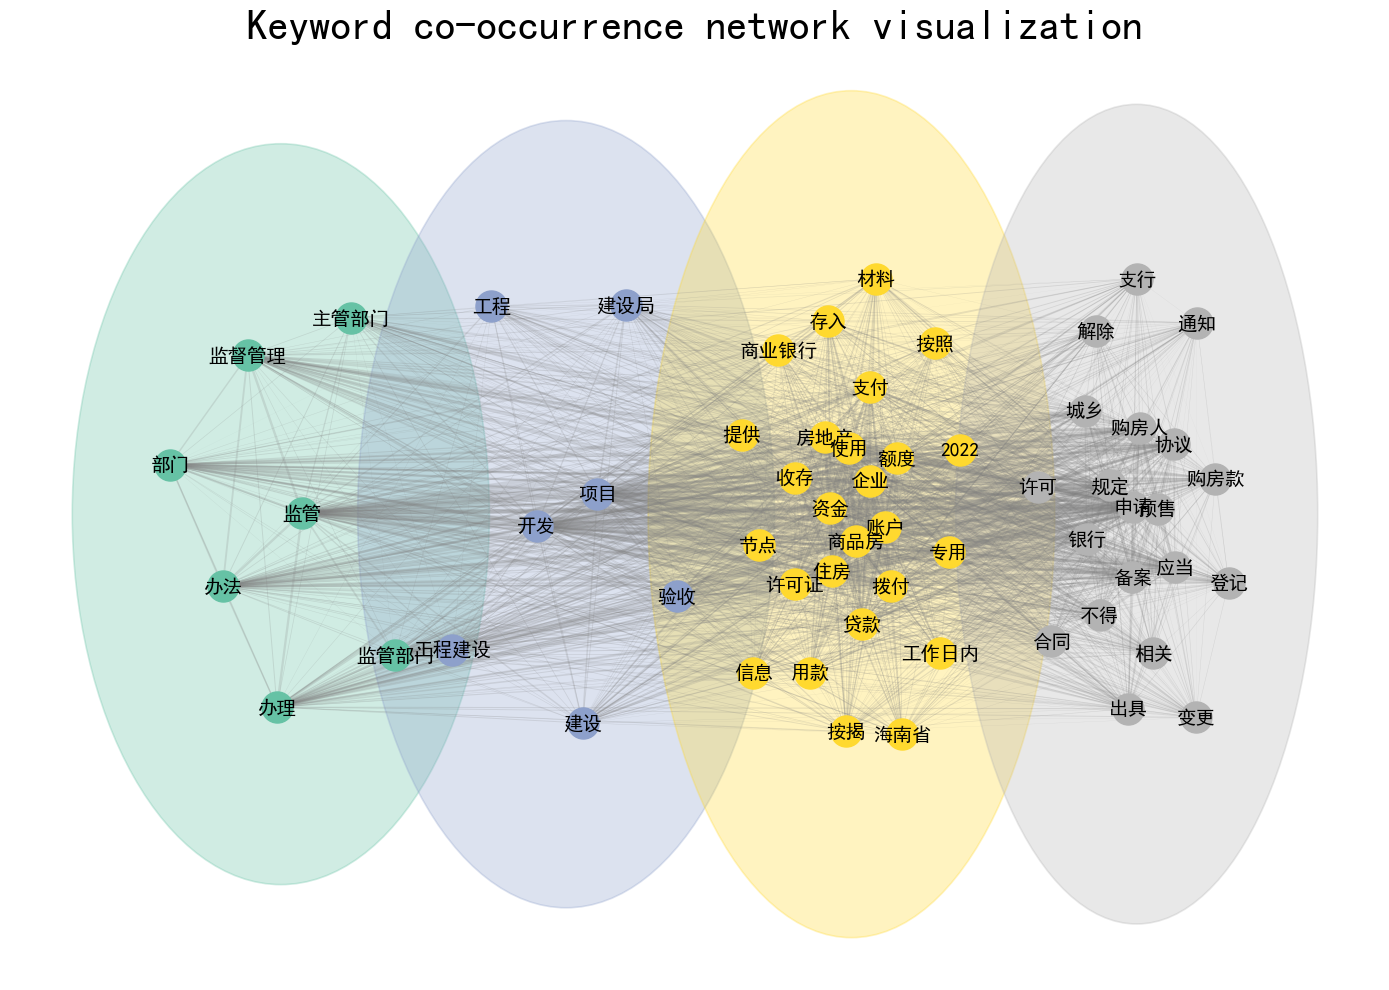

In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib import colormaps
from matplotlib.patches import Ellipse

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ÂÅáËÆæ keyword_embeddings Âíå adj_df Â∑≤ÁªèÂú®ÂÖ∂‰ªñÂú∞ÊñπÂÆö‰πâ
# Â¶ÇÊûúÊ≤°ÊúâÂÆö‰πâÔºåËØ∑Á°Æ‰øùÂú®Ê≠§‰πãÂâçÂÆö‰πâÊàñ‰ªéÊñá‰ª∂‰∏≠ËØªÂèñËøô‰∫õÂèòÈáè

# -----------------------------
# 1. Ëá™Âä®ÁªüËÆ°ÂÖ≥ÈîÆËØçÈ¢ëÁéá
# -----------------------------
kw_freq_series = adj_df.sum(axis=1)
kw_counter = kw_freq_series.sort_values(ascending=False)

top_keywords = kw_counter.head(60).index.tolist()

# 2. ÂµåÂÖ•Áü©Èòµ
embeddings_matrix = []
valid_keywords = []

for kw in top_keywords:
    if kw in keyword_embeddings:
        embeddings_matrix.append(keyword_embeddings[kw])
        valid_keywords.append(kw)
    else:
        print(f"‚ö†Ô∏è Áº∫Â∞ëÂµåÂÖ•ÂêëÈáèÔºåË∑≥ËøáÔºö{kw}")

embeddings_matrix = np.array(embeddings_matrix)

# 3. KMeans ËÅöÁ±ª
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto').fit(embeddings_matrix)
labels = kmeans.labels_

# ÊûÑÂª∫È¢úËâ≤Êò†Â∞Ñ
colors = colormaps['Set2'].resampled(n_clusters)
node_colors = {kw: colors(labels[idx]) for idx, kw in enumerate(valid_keywords)}
label_dict = {kw: labels[idx] for idx, kw in enumerate(valid_keywords)}

# -----------------------------
# 4. ÊûÑÂª∫ÁΩëÁªúÂõæ
# -----------------------------
G = nx.Graph()
for kw in valid_keywords:
    G.add_node(kw, cluster=node_colors[kw], label=label_dict[kw])

adj_df_top = adj_df.loc[valid_keywords, valid_keywords]

for i, kw_i in enumerate(valid_keywords):
    for j, kw_j in enumerate(valid_keywords):
        if i < j:
            weight = adj_df_top.loc[kw_i, kw_j]
            if weight > 0:
                G.add_edge(kw_i, kw_j, weight=weight)

# -----------------------------
# 5. ËÅöÁ±ªÊÑüÁü•Â∏ÉÂ±ÄÔºàÁ∞áÂÜÖÈõÜ‰∏≠Ôºâ
# -----------------------------
# ÂÖàÊåâËÅöÁ±ªÂàÜÁªÑËäÇÁÇπ
clusters = {i: [] for i in range(n_clusters)}
for node in G.nodes():
    clusters[G.nodes[node]['label']].append(node)

# ‰∏∫ÊØè‰∏™Á∞áÂàõÂª∫Â≠êÂ∏ÉÂ±ÄÔºåÂÜçÂêàÂπ∂Âà∞ÊÄªÂõæ‰∏ä
pos = {}
x_offset = 0
for cluster_id, nodes in clusters.items():
    subgraph = G.subgraph(nodes)
    # Â±ÄÈÉ®Â∏ÉÂ±Ä
    sub_pos = nx.spring_layout(subgraph, seed=cluster_id, k=0.8)
    # Ê∑ªÂä†ÂÅèÁßªÈáèÔºå‰ΩøÊØè‰∏™Á∞áÂàÜÂºÄ
    for node in sub_pos:
        sub_pos[node][0] += x_offset
    # ÂêàÂπ∂ËøõÂÖ®ÂõæÂ∏ÉÂ±Ä
    pos.update(sub_pos)
    x_offset += 2.5  # Á∞á‰πãÈó¥Ê®™ÂêëÈó¥Èöî

# -----------------------------
# 6. ÁªòÂõæÔºàÁªÜËæπ + ‰∏≠Êñá + ËÅöÁ±ªÊÑüÁü•Â∏ÉÂ±ÄÔºâ
# -----------------------------
plt.figure(figsize=(14, 10))
ax = plt.gca()

# === È¢úËâ≤ÂåÖÂõ¥Ê°ÜÔºàËÅöÁ±ªËâ≤ÂùóÂ°´ÂÖÖÔºâ ===
for cluster_id, nodes in clusters.items():
    cluster_pos = np.array([pos[n] for n in nodes])
    x_center = np.mean(cluster_pos[:, 0])
    y_center = np.mean(cluster_pos[:, 1])
    x_span = cluster_pos[:, 0].max() - cluster_pos[:, 0].min()
    y_span = cluster_pos[:, 1].max() - cluster_pos[:, 1].min()
    width = x_span * 1.6 + 0.5
    height = y_span * 1.6 + 0.5

    # Áî® cluster Ëâ≤ÂΩ©‰Ωú‰∏∫ÂçäÈÄèÊòéËÉåÊôØËâ≤Âùó
    ellipse = Ellipse((x_center, y_center), width, height,
                      edgecolor=colors(cluster_id),        # ËæπÊ°ÜËâ≤ÔºàÂèØÈÄâÔºâ
                      facecolor=colors(cluster_id),        # Â°´ÂÖÖËâ≤
                      linewidth=1.2,
                      linestyle='solid',
                      alpha=0.3)                          # ÈÄèÊòéÂ∫¶ÊéßÂà∂
    ax.add_patch(ellipse)

# === ËäÇÁÇπ ===
for kw in G.nodes():
    nx.draw_networkx_nodes(G, pos,
                           nodelist=[kw],
                           node_color=[G.nodes[kw]['cluster']],
                           node_size=500)

# === Ê†áÁ≠æ ===
nx.draw_networkx_labels(G, pos, font_family='SimHei', font_size=14, font_color='black',
                       font_weight='bold', verticalalignment='center',)

# === Ëæπ ===
edges = G.edges(data=True)
for (u, v, d) in edges:
    w = d['weight']
    nx.draw_networkx_edges(G, pos,
                           edgelist=[(u, v)],
                           width=w * 0.1,  # Á∫øÂÆΩ
                           edge_color='gray',
                           alpha=0.2, 
                           connectionstyle='arc3,rad=0.2')

plt.title("Keyword co-occurrence network visualization", fontsize=30, fontweight='bold')
# plt.xlim(-3, 3)
plt.axis('off')
plt.tight_layout()
plt.show()


# <b>PMC-frequency

In [7]:
import re
import jieba

# ÂÆö‰πâÊñáÊú¨È¢ÑÂ§ÑÁêÜÂáΩÊï∞ÔºåÊâßË°åÁâπÊÆäÂ≠óÁ¨¶Ê∏ÖÊ¥ó„ÄÅ‰∏≠ÊñáÂàÜËØçÂíåÂÅúÁî®ËØçËøáÊª§
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    # ÂéªÈô§Èùû‰∏≠ÊñáÂ≠óÁ¨¶
    text = re.sub(r'[^\u4e00-\u9fa5]', ' ', text)
    # ‰ΩøÁî®jiebaËøõË°å‰∏≠ÊñáÂàÜËØç
    words = jieba.cut(text)
    # ÂÆö‰πâÁÆÄÂçïÁöÑÂÅúÁî®ËØçÈõÜÂêàÔºàÂÆûÈôÖÂ∫îÁî®Êó∂Â∫îÂä†ËΩΩÂÆåÊï¥ÁöÑÂÅúÁî®ËØçË°®Ôºâ
    stopwords = {'ÁöÑ', '‰∫Ü', 'Âíå', 'ÊòØ', 'Âú®', '‰ª•', 'ÂØπ', 'Á≠â', '‰∏é', '‰∏≠', 'Â∞Ü', '‰∏∫'}
    filtered_words = [word for word in words if word.strip() and word not in stopwords and len(word) > 1]
    return ' '.join(filtered_words)

# Â∫îÁî®È¢ÑÂ§ÑÁêÜÂáΩÊï∞
print("Ê≠£Âú®ËøõË°åÊñáÊú¨È¢ÑÂ§ÑÁêÜ...")
df_policies['processed_text'] = df_policies['content'].apply(preprocess_text)

df_policies['processed_text'].head(10)


Ê≠£Âú®ËøõË°åÊñáÊú¨È¢ÑÂ§ÑÁêÜ...


0    ‰∏áÂÆÅÂ∏Ç ‰∫∫Ê∞ëÊîøÂ∫ú ÂäûÂÖ¨ÂÆ§ ÂÖ≥‰∫é Âç∞Âèë ‰∏áÂÆÅÂ∏Ç ÂïÜÂìÅÊàø È¢ÑÂîÆ ËµÑÈáë ÁõëÁÆ° ÂÆûÊñΩÁªÜÂàô ÈÄöÁü• ÂêÑÈïá...
1    ‰∏äÊµ∑Â∏Ç ÂÖ®È¢ù ÁõëÁÆ° Ê∂âÂèä Áî®ÈÄî ÊîØ‰ªò Á¨¨‰∏âÊñπ Ë¥¶Êà∑ ÊîøÂ∫ú Âêç‰∏ã ÂÖ¨Âè∏ ÁõëÁÆ° È°πÁõÆ Âª∫ËÆæ ÂèëÁîü...
2    ‰∏äÈ•∂Â∏Ç ÊàøÂú∞‰∫ß ÁÆ°ÁêÜÂ±Ä ÂÖ≥‰∫é Ëøõ‰∏ÄÊ≠• Âä†Âº∫ ÂïÜÂìÅÊàø È¢ÑÂîÆ ÁÆ°ÁêÜÂ∑•‰Ωú ÈÄöÁü• È¢ÅÂ∏É Âçï‰Ωç ‰∏äÈ•∂Â∏Ç...
3    ÂÖ≥‰∫é ÂæÅÊ±Ç ‰∏úÊñπ ÂïÜÂìÅÊàø È¢ÑÂîÆ ËµÑÈáë ÁõëÁÆ° ÂÆûÊñΩÁªÜÂàô ÂæÅÊ±ÇÊÑèËßÅ ÊÑèËßÅ ÂÖ¨Âëä Âä†Âº∫ ÂïÜÂìÅÊàø È¢Ñ...
4    ‰∏úËéûÂ∏Ç ‰ΩèÊàø Âüé‰π° Âª∫ËÆæÂ±Ä ÂÖ≥‰∫é Ëøõ‰∏ÄÊ≠• Âä†Âº∫ ÂïÜÂìÅÊàø È¢ÑÂîÆ ‰ΩøÁî® Â∑ÆÂºÇÂåñ ÁÆ°ÁêÜ ÈÄöÁü• ËéûÂª∫...
5    ÂÖ≥‰∫é Âç∞Âèë ‰∏úËê•Â∏Ç ÂïÜÂìÅÊàø È¢ÑÂîÆ ËµÑÈáë ÁõëÁÆ° ÂäûÊ≥ï ÈÄöÁü• ÂèëÂ∏É Êó•Êúü ‰ø°ÊÅØ Êù•Ê∫ê ‰∏úËê•Â∏Ç ‰Ωè...
6    ÊïàÂäõ Áä∂ÊÄÅ ÊúâÊïà ÂèëÂ∏É Êú∫ÊûÑ ‰∏≠Âç´Â∏Ç ‰ΩèÊàø Âüé‰π° Âª∫ËÆæÂ±Ä ÊàêÊñá Êó•Êúü Ë¥£‰ªª ÈÉ®Èó® ‰∏≠Âç´Â∏Ç ‰Ωè...
7    ÁÅ´ÁÇ¨ ÂºÄÂèëÂå∫ ÁÆ°Âßî‰ºö Áø†‰∫® Êñ∞Âå∫ ÁÆ°Âßî‰ºö ÈïáÊîøÂ∫ú Âäû‰∫ãÂ§Ñ ÊúâÂÖ≥ Âçï‰Ωç Áé∞Â∞Ü ‰∏≠Â±±Â∏Ç ÂïÜÂìÅÊàø ...
8    ‰∏≠Âçé‰∫∫Ê∞ëÂÖ±ÂíåÂõΩ ÂüéÂ∏Ç 

In [8]:
import numpy as np
from collections import Counter

def compute_pmc_index(processed_text):
    """
    ËÆ°ÁÆóPMCÊåáÊï∞Ôºö
    X_i = (Âπ≥ÂùáËØçÈ¢ë) * œâ_iÔºåÂÖ∂‰∏≠ œâ_i ‰∏∫ËØçÈ¢ëÊÄªÂíåÁöÑÂØπÊï∞ÔºàÁ§∫‰æãËÆ°ÁÆóÔºåÂèØÊåâÂÆûÈôÖÈúÄÊ±ÇË∞ÉÊï¥Ôºâ
    """
    # ÂàÜËØçÂàóË°®
    tokens = processed_text.split()
    if len(tokens) == 0:
        return 0
    # ËÆ°ÁÆóÊØè‰∏™ËØçÁöÑÈ¢ëÊï∞
    token_counts = Counter(tokens)
    total_frequency = sum(token_counts.values())
    # Âπ≥ÂùáËØçÈ¢ë
    avg_frequency = total_frequency / len(token_counts)
    # ÊùÉÈáçÂõ†Â≠ê œâ_i: ËøôÈáåÈááÁî®ÊÄªËØçÈ¢ëÁöÑÂØπÊï∞ÔºàÂä†1Èò≤Ê≠¢ÂèñÂØπÊï∞0Ôºâ
    omega_i = np.log(total_frequency + 1)
    # ËÆ°ÁÆóPMCÊåáÊï∞
    pmc_index = avg_frequency * omega_i
    return pmc_index

# ÂØπÊâÄÊúâÊîøÁ≠ñÊñáÊú¨ËÆ°ÁÆóPMCÊåáÊï∞ÔºåÂπ∂‰øùÂ≠òÂà∞Êñ∞Âàó
print("ËÆ°ÁÆóÊîøÁ≠ñÂª∫Ê®°‰∏ÄËá¥ÊÄßÊåáÊï∞ (PMC)...")
df_policies['PMC_indexF'] = df_policies['processed_text'].apply(compute_pmc_index)
df_policies[['content', 'PMC_indexF']].head(10)

# Ê≠•È™§1Ôºö‰øùÂ≠òÂéüÂßãPMCÁªìÊûúÔºåÈÅøÂÖçË¶ÜÁõñ
df_policies['PMC_index_raw'] = df_policies['PMC_indexF']

# Ê≠•È™§2ÔºöÂΩí‰∏ÄÂåñ PMC_indexF Âà∞ [0, 10]
min_val = df_policies['PMC_index_raw'].min()
max_val = df_policies['PMC_index_raw'].max()

if max_val - min_val == 0:
    df_policies['PMC_indexF'] = 0  # Ëã•ÊâÄÊúâÂÄºÁõ∏Á≠âÔºåÂΩí‰∏ÄÂåñÁªìÊûú‰∏∫0
else:
    df_policies['PMC_indexF'] = 10 * (df_policies['PMC_index_raw'] - min_val) / (max_val - min_val)

# Ê≠•È™§3ÔºöÊòæÁ§∫Ââç10Êù°ÁªìÊûú
print("\nÂΩí‰∏ÄÂåñÂêé PMC_indexF Ââç10Êù°Ôºö")
print(df_policies[['content', 'PMC_indexF']].head(10))

# Ê≠•È™§4ÔºöËæìÂá∫ÊèèËø∞ÊÄßÁªüËÆ°
stats = df_policies['PMC_indexF'].agg(['mean', 'std', 'min', 'max'])
stats.index = ['ÂùáÂÄº', 'Ê†áÂáÜÂ∑Æ', 'ÊúÄÂ∞èÂÄº', 'ÊúÄÂ§ßÂÄº']

print("\nPMC_indexF ÊèèËø∞ÊÄßÁªüËÆ°Ôºö")
print(stats)



ËÆ°ÁÆóÊîøÁ≠ñÂª∫Ê®°‰∏ÄËá¥ÊÄßÊåáÊï∞ (PMC)...

ÂΩí‰∏ÄÂåñÂêé PMC_indexF Ââç10Êù°Ôºö
                                             content  PMC_indexF
0  ‰∏áÂÆÅÂ∏Ç‰∫∫Ê∞ëÊîøÂ∫úÂäûÂÖ¨ÂÆ§ÂÖ≥‰∫éÂç∞Âèë\n‰∏áÂÆÅÂ∏ÇÂïÜÂìÅÊàøÈ¢ÑÂîÆËµÑÈáëÁõëÁÆ°ÂÆûÊñΩÁªÜÂàôÁöÑÈÄöÁü•\nÂêÑÈïá‰∫∫Ê∞ëÊîøÂ∫úÔºåÂÖ¥ÈöÜ...    1.543829
1  ‰∏äÊµ∑Â∏Ç\nÂÖ®È¢ùÁõëÁÆ°\n‰∏çÊ∂âÂèä„ÄÅÊåâÁî®ÈÄîÊîØ‰ªò\nÁ¨¨‰∏âÊñπË¥¶Êà∑ÔºàÊîøÂ∫úÂêç‰∏ãÂÖ¨Âè∏ÔºâÁõëÁÆ°\nÊú¨È°πÁõÆÂª∫ËÆæËÄåÂèë...    1.277806
2  \n‰∏äÈ•∂Â∏ÇÊàøÂú∞‰∫ßÁÆ°ÁêÜÂ±ÄÂÖ≥‰∫éËøõ‰∏ÄÊ≠•Âä†Âº∫ÂïÜÂìÅÊàøÈ¢ÑÂîÆÁÆ°ÁêÜÂ∑•‰ΩúÁöÑÈÄöÁü• \nÈ¢ÅÂ∏ÉÂçï‰Ωç Ôºö‰∏äÈ•∂Â∏ÇÊàøÂú∞‰∫ßÁÆ°...    1.329864
3  ÂÖ≥‰∫éÂæÅÊ±Ç„Ää‰∏úÊñπÂ∏ÇÂïÜÂìÅÊàøÈ¢ÑÂîÆËµÑÈáëÁõëÁÆ°ÂÆûÊñΩÁªÜÂàôÔºàÂæÅÊ±ÇÊÑèËßÅÁ®øÔºâ„ÄãÊÑèËßÅÁöÑÂÖ¨Âëä\n\n\n‰∏∫Âä†Âº∫ÂïÜÂìÅÊàø...    1.971327
4  ‰∏úËéûÂ∏Ç‰ΩèÊàøÂíåÂüé‰π°Âª∫ËÆæÂ±ÄÂÖ≥‰∫éËøõ‰∏ÄÊ≠•Âä†Âº∫ÂïÜÂìÅÊàøÈ¢ÑÂîÆÊ¨æ‰ΩøÁî®Â∑ÆÂºÇÂåñÁÆ°ÁêÜÁöÑÈÄöÁü•\nËéûÂª∫ÂÆ£¬†‰∏úËéûÂ∏Ç‰ΩèÊàøÂíå...    6.202943
5  ÂÖ≥‰∫éÂç∞Âèë„Ää‰∏úËê•Â∏ÇÂïÜÂìÅÊàøÈ¢ÑÂîÆËµÑÈáëÁõëÁÆ°ÂäûÊ≥ï„ÄãÁöÑÈÄöÁü•\nÂèëÂ∏ÉÊó•ÊúüÔºöÔºö2023-02-20\n‰ø°ÊÅØÊù•...   10.0

# <b>PMC-BERT </b>

ber-base-chinese
<p>Âü∫‰∫éBERTÁöÑPMC</p>

In [13]:
import re
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)



# Âä†ËΩΩbert-base-chineseÊ®°ÂûãÂèäÂÖ∂ÂàÜËØçÂô®ÔºàÂèØÂú®ÂÖ®Â±ÄÂä†ËΩΩÔºåÈÅøÂÖçÈáçÂ§çÂä†ËΩΩÔºâ
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
model = AutoModel.from_pretrained("bert-base-chinese")
model.eval()  # ËÆæÁΩÆÊ®°Âûã‰∏∫ËØÑ‰º∞Ê®°Âºè

def compute_pmc_index_bert(processed_text):
    """
    Âü∫‰∫éBERTÂµåÂÖ•ÁöÑPMCÊåáÊï∞ËÆ°ÁÆóÔºà‰øÆËÆ¢ÁâàÔºâÔºö
    
    1. Â∞ùËØïÊåâÁÖß‰∏≠ÊñáÂè•Âè∑„ÄÅÊÑüÂèπÂè∑„ÄÅÈóÆÂè∑ÂàÜÂâ≤ÊñáÊú¨‰∏∫Âè•Â≠êÔºõ
    2. Ëã•ÂàÜÂâ≤ÁªìÊûú‰∏çË∂≥2ÔºåÂàôÂ∞ùËØïÊåâ‰∏≠ÊñáÈÄóÂè∑„ÄÅÈ°øÂè∑„ÄÅÂàÜÂè∑ÂàÜÂâ≤‰∏∫Â≠êÂè•Ôºõ
    3. Ëã•‰ªç‰∏çË∂≥2ÔºåÂàôÂ∞ÜÊñáÊú¨ÊåâÂ≠óÁ¨¶Êï∞Âπ≥ÂùáÂàáÂàÜ‰∏∫‰∏§ÈÉ®ÂàÜÔºõ
    4. ÂØπÊØè‰∏™ÂàÜÊÆµÁîüÊàêBERTÂµåÂÖ•ÔºàÂèñ[CLS]Ê†áËÆ∞ÔºâÔºåËÆ°ÁÆóÂêÑÂàÜÊÆµÈó¥ÁöÑ‰ΩôÂº¶Áõ∏‰ººÂ∫¶ÔºåÂπ∂ËøîÂõû‰∏ä‰∏âËßíÂπ≥ÂùáÂÄº‰Ωú‰∏∫PMCÊåáÊï∞„ÄÇ
    """
    # Â∞ùËØï‰ΩøÁî®‰∏≠ÊñáÂè•Âè∑„ÄÅÊÑüÂèπÂè∑„ÄÅÈóÆÂè∑ÂàÜÂâ≤ÊñáÊú¨
    sentences = re.split(r'[„ÄÇÔºÅÔºü]', processed_text)
    sentences = [s.strip() for s in sentences if s.strip()]
    
    if len(sentences) < 2:
        # Ëã•Âè•Â≠êÊï∞‰∏çË∂≥2ÔºåÂ∞ùËØïÊåâ‰∏≠ÊñáÈÄóÂè∑„ÄÅÈ°øÂè∑„ÄÅÂàÜÂè∑ÂàÜÂâ≤
        clauses = re.split(r'[Ôºå„ÄÅÔºõ]', processed_text)
        clauses = [s.strip() for s in clauses if s.strip()]
        if len(clauses) >= 2:
            segments = clauses
        else:
            # Ëã•‰ªç‰∏çË∂≥2ÔºåÂàôÂ∞ÜÊñáÊú¨ÊåâÂ≠óÁ¨¶Êï∞Âπ≥ÂùáÂàáÂàÜ‰∏∫‰∏§ÈÉ®ÂàÜ
            midpoint = len(processed_text) // 2
            segment1 = processed_text[:midpoint].strip()
            segment2 = processed_text[midpoint:].strip()
            segments = [segment1, segment2]
    else:
        segments = sentences

    # ‰∏∫ÊØè‰∏™ÂàÜÊÆµÁîüÊàêBERTÂµåÂÖ•
    sentence_embeddings = []
    with torch.no_grad():
        for seg in segments:
            inputs = tokenizer(seg, return_tensors="pt", truncation=True, max_length=128)
            outputs = model(**inputs)
            # ÈááÁî®[CLS]Ê†áËÆ∞ÁöÑÂêëÈáè‰Ωú‰∏∫ÂàÜÊÆµË°®Á§∫
            cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()  # shape: (1, hidden_size)
            sentence_embeddings.append(cls_embedding[0])
    
    sentence_embeddings = np.array(sentence_embeddings)
    
    # ËÆ°ÁÆóÂàÜÊÆµÈó¥ÁöÑ‰ΩôÂº¶Áõ∏‰ººÂ∫¶Áü©Èòµ
    sim_matrix = cosine_similarity(sentence_embeddings)
    n = sim_matrix.shape[0]
    # Âèñ‰∏ä‰∏âËßíÔºà‰∏çÂê´ÂØπËßíÁ∫øÔºâÁöÑÁõ∏‰ººÂ∫¶Âπ≥ÂùáÂÄº
    upper_tri_indices = np.triu_indices(n, k=1)
    average_similarity = sim_matrix[upper_tri_indices].mean()
    
    return average_similarity

# ÂØπÊâÄÊúâÊîøÁ≠ñÊñáÊú¨ËÆ°ÁÆóÂü∫‰∫éBERTÁöÑPMCÊåáÊï∞ÔºåÂπ∂‰øùÂ≠òÂà∞Êñ∞Âàó
print("ËÆ°ÁÆóÂü∫‰∫éBERTÁöÑPMCÊåáÊï∞...")
df_policies['PMC_index_bert'] = df_policies['processed_text'].apply(compute_pmc_index_bert)
print(df_policies[['content', 'PMC_index_bert']].head())

# Ê≠•È™§1Ôºö‰øùÂ≠òÂéüÂßãÂÄº‰ª•‰æøÂèØÈáçÂ§ç‰ΩøÁî®
df_policies['PMC_index_bert_raw'] = df_policies['PMC_index_bert']

# Ê≠•È™§2ÔºöÂΩí‰∏ÄÂåñ PMC_index_bert Âà∞ [0, 10]
min_bert = df_policies['PMC_index_bert_raw'].min()
max_bert = df_policies['PMC_index_bert_raw'].max()

if max_bert - min_bert == 0:
    df_policies['PMC_index_bert'] = 0
else:
    df_policies['PMC_index_bert'] = 10 * (df_policies['PMC_index_bert_raw'] - min_bert) / (max_bert - min_bert)

# Ê≠•È™§3ÔºöËæìÂá∫ÂâçÂá†Êù°ËÆ∞ÂΩïÔºåËßÇÂØüÂΩí‰∏ÄÂåñÂêéÁªìÊûú
print("\nÂΩí‰∏ÄÂåñÂêéÁöÑ PMC_index_bertÔºàÂâç5Êù°ÔºâÔºö")
print(df_policies[['content', 'PMC_index_bert']].head())

# Ê≠•È™§4ÔºöËæìÂá∫ÊèèËø∞ÊÄßÁªüËÆ°‰ø°ÊÅØ
bert_stats = df_policies['PMC_index_bert'].agg(['mean', 'std', 'min', 'max'])
bert_stats.index = ['ÂùáÂÄº', 'Ê†áÂáÜÂ∑Æ', 'ÊúÄÂ∞èÂÄº', 'ÊúÄÂ§ßÂÄº']

print("\nPMC_index_bert ÊèèËø∞ÊÄßÁªüËÆ°Ôºö")
print(bert_stats)



ËÆ°ÁÆóÂü∫‰∫éBERTÁöÑPMCÊåáÊï∞...
                                             content  PMC_index_bert
0  ‰∏áÂÆÅÂ∏Ç‰∫∫Ê∞ëÊîøÂ∫úÂäûÂÖ¨ÂÆ§ÂÖ≥‰∫éÂç∞Âèë\n‰∏áÂÆÅÂ∏ÇÂïÜÂìÅÊàøÈ¢ÑÂîÆËµÑÈáëÁõëÁÆ°ÂÆûÊñΩÁªÜÂàôÁöÑÈÄöÁü•\nÂêÑÈïá‰∫∫Ê∞ëÊîøÂ∫úÔºåÂÖ¥ÈöÜ...        0.611719
1  ‰∏äÊµ∑Â∏Ç\nÂÖ®È¢ùÁõëÁÆ°\n‰∏çÊ∂âÂèä„ÄÅÊåâÁî®ÈÄîÊîØ‰ªò\nÁ¨¨‰∏âÊñπË¥¶Êà∑ÔºàÊîøÂ∫úÂêç‰∏ãÂÖ¨Âè∏ÔºâÁõëÁÆ°\nÊú¨È°πÁõÆÂª∫ËÆæËÄåÂèë...        0.761268
2  \n‰∏äÈ•∂Â∏ÇÊàøÂú∞‰∫ßÁÆ°ÁêÜÂ±ÄÂÖ≥‰∫éËøõ‰∏ÄÊ≠•Âä†Âº∫ÂïÜÂìÅÊàøÈ¢ÑÂîÆÁÆ°ÁêÜÂ∑•‰ΩúÁöÑÈÄöÁü• \nÈ¢ÅÂ∏ÉÂçï‰Ωç Ôºö‰∏äÈ•∂Â∏ÇÊàøÂú∞‰∫ßÁÆ°...        0.819977
3  ÂÖ≥‰∫éÂæÅÊ±Ç„Ää‰∏úÊñπÂ∏ÇÂïÜÂìÅÊàøÈ¢ÑÂîÆËµÑÈáëÁõëÁÆ°ÂÆûÊñΩÁªÜÂàôÔºàÂæÅÊ±ÇÊÑèËßÅÁ®øÔºâ„ÄãÊÑèËßÅÁöÑÂÖ¨Âëä\n\n\n‰∏∫Âä†Âº∫ÂïÜÂìÅÊàø...        0.781842
4  ‰∏úËéûÂ∏Ç‰ΩèÊàøÂíåÂüé‰π°Âª∫ËÆæÂ±ÄÂÖ≥‰∫éËøõ‰∏ÄÊ≠•Âä†Âº∫ÂïÜÂìÅÊàøÈ¢ÑÂîÆÊ¨æ‰ΩøÁî®Â∑ÆÂºÇÂåñÁÆ°ÁêÜÁöÑÈÄöÁü•\nËéûÂª∫ÂÆ£¬†‰∏úËéûÂ∏Ç‰ΩèÊàøÂíå...        0.754123

ÂΩí‰∏ÄÂåñÂêéÁöÑ PMC_index_bertÔºàÂâç5Êù°ÔºâÔºö
                                             content  PMC_index_bert
0  ‰∏áÂÆÅÂ∏Ç‰∫∫Ê∞ëÊîøÂ∫úÂäûÂÖ¨

# <b>PMC-T and PMC-I reading and analysis
Relationship among 4 PMC indexes

Computed policies count: 41
Evaluation data count: 41
Pairwise Pearson correlation matrix:
               PMC_Frequency  PMC_BERT     PMC_T     PMC_I
PMC_Frequency       1.000000  0.205263  0.023532  0.008716
PMC_BERT            0.205263  1.000000  0.293368  0.307982
PMC_T               0.023532  0.293368  1.000000  0.913776
PMC_I               0.008716  0.307982  0.913776  1.000000


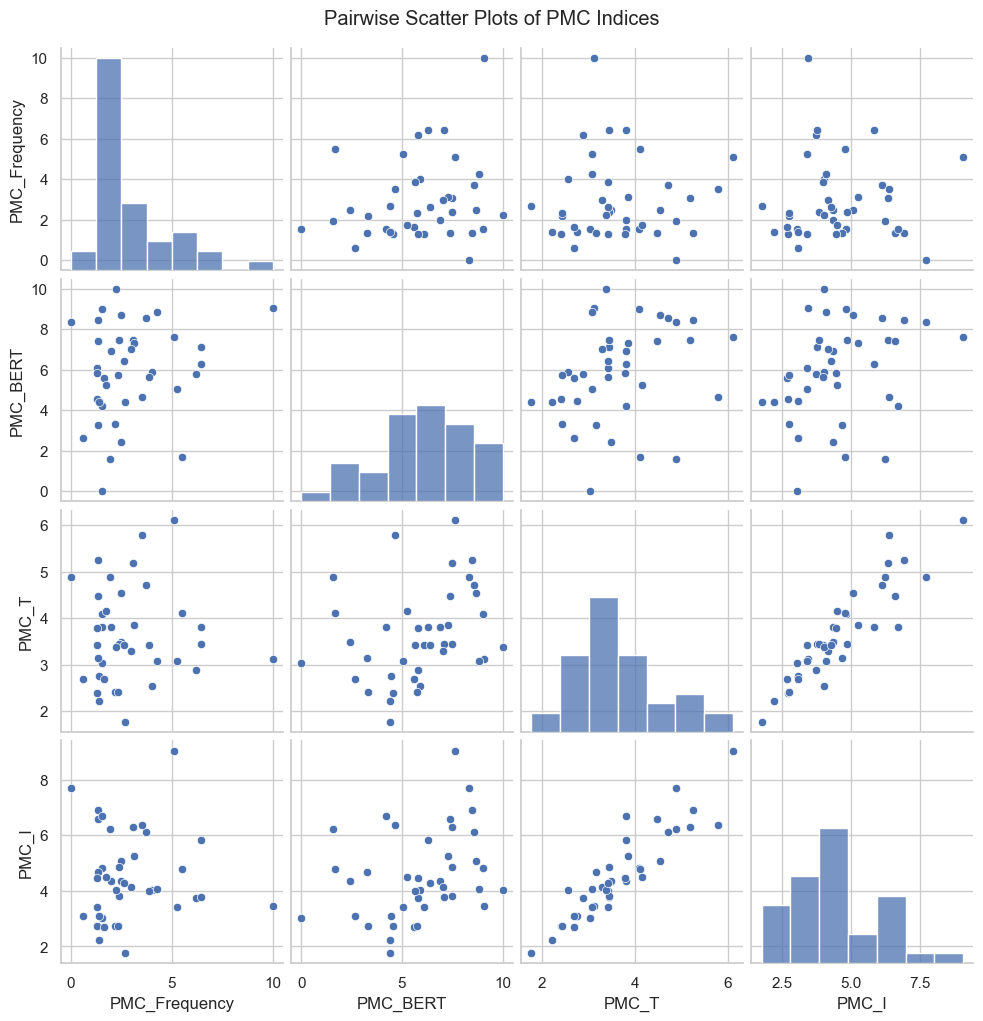

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. ËØªÂèñExcelÊñá‰ª∂‰∏≠PMC-TÂíåPMC-IÊï∞ÊçÆ
excel_path = r"\\your_file\\code\ÊµãËØï‰ø°ÊïàÂ∫¶ÁöÑÊï∞ÊçÆ_.xlsx"
sheet_name = "Evaluation-transfer"
# Ê≥®ÊÑèÔºöË∑≥ËøáÂâç271Ë°åÔºåËØªÂèñÊé•‰∏ãÊù•ÁöÑ41Ë°åÔºàÂØπÂ∫îExcel‰∏≠ÁöÑB272:C312ÔºâÔºå‰ΩøÁî®Êó†Ê†áÈ¢òÊ®°ÂºèÂêéÊâãÂä®ÂëΩÂêçÂàó
df_evaluation = pd.read_excel(excel_path, sheet_name=sheet_name, header=None, skiprows=271, nrows=41, usecols="B:C")
df_evaluation.columns = ["PMC_T", "PMC_I"]

# 2. ÂêàÂπ∂ÂõõÁßçPMCÂèÇÊï∞Êï∞ÊçÆ
# ÂÅáËÆæ‰πãÂâçËÆ°ÁÆóÁöÑPMCÊåáÊï∞Â≠òÂÇ®Âú®DataFrame df_policies‰∏≠Ôºå
# ‰∏îÂåÖÂê´‰∏§ÂàóÔºö 'PMC_index'ÔºàËØçÈ¢ëÊ≥ïÔºåÂØπÂ∫îPMC-FrequencyÔºâÂíå 'PMC_index_bert'ÔºàÂü∫‰∫éBERTÔºåÂØπÂ∫îPMC-BERTÔºâ„ÄÇ
# ‰∏∫‰æø‰∫éÁêÜËß£ÔºåÈáçÂëΩÂêçËøô‰∏§ÂàóÔºö
df_policies = df_policies.rename(columns={"PMC_indexF": "PMC_Frequency", "PMC_index_bert": "PMC_BERT"})

# Ê£ÄÊü•Êï∞ÊçÆË°åÊï∞ÊòØÂê¶‰∏ÄËá¥ÔºàÂ∫î‰∏∫41‰∏™Ê†∑Êú¨Ôºâ
print(f"Computed policies count: {len(df_policies)}")
print(f"Evaluation data count: {len(df_evaluation)}")

# ÂÅáÂÆö‰∏§ÈÉ®ÂàÜÊï∞ÊçÆÈ°∫Â∫è‰∏ÄËá¥ÔºåÁõ¥Êé•ÂêàÂπ∂‰∏∫‰∏Ä‰∏™DataFrame
df_combined = df_policies.copy()
df_combined['PMC_T'] = df_evaluation["PMC_T"].values
df_combined['PMC_I'] = df_evaluation["PMC_I"].values

# 3. ‰∏§‰∏§È™åËØÅÔºöËÆ°ÁÆóÁöÆÂ∞îÈÄäÁõ∏ÂÖ≥Á≥ªÊï∞Âπ∂ÁªòÂà∂Êï£ÁÇπÂõæ
pmc_columns = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

# 3.1 ËÆ°ÁÆóÁöÆÂ∞îÈÄäÁõ∏ÂÖ≥Á≥ªÊï∞Áü©Èòµ
correlation_matrix = df_combined[pmc_columns].corr(method='pearson')
print("Pairwise Pearson correlation matrix:")
print(correlation_matrix)

# 3.2 ÁªòÂà∂Êï£ÁÇπÂõæÁü©ÈòµÔºåÁõ¥ËßÇÂ±ïÁ§∫ÂêÑÂèÇÊï∞Èó¥ÁöÑÂÖ≥Á≥ª
sns.set(style="whitegrid")
pairplot_fig = sns.pairplot(df_combined[pmc_columns])
pairplot_fig.fig.suptitle("Pairwise Scatter Plots of PMC Indices", y=1.02)
plt.savefig("PMC_pairwise_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


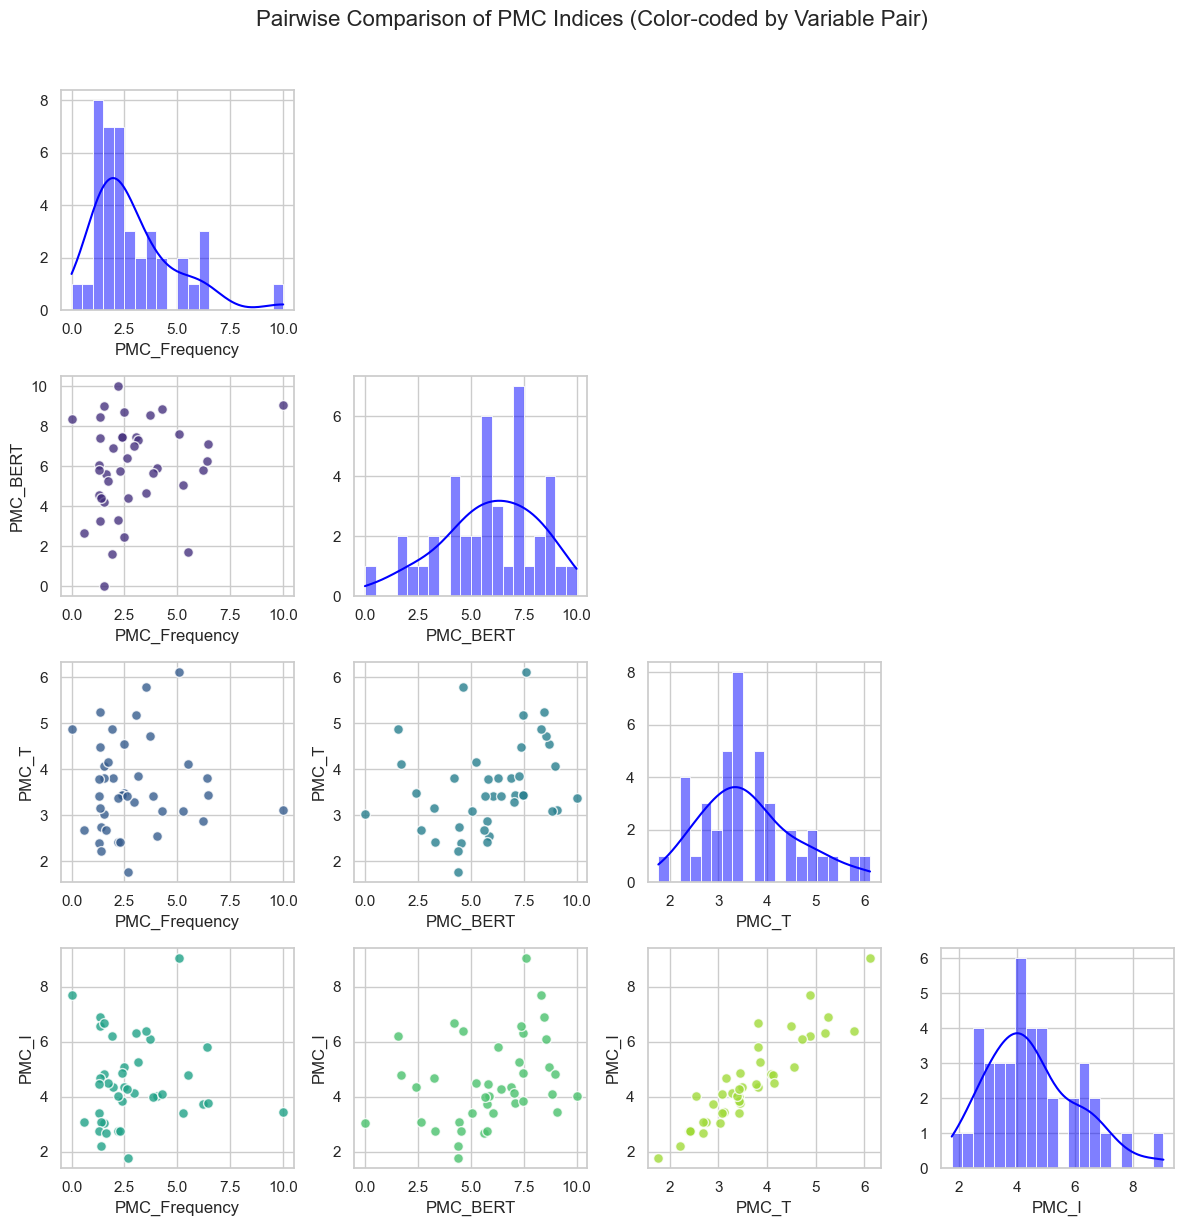

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# ËÆæÁΩÆÂèòÈáèÂèäÈ¢úËâ≤
pmc_columns = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]
num_vars = len(pmc_columns)
viridis_colors = sns.color_palette("viridis", n_colors=(num_vars * (num_vars - 1)) // 2)

# ÂàõÂª∫Â≠êÂõæÁΩëÊ†º
fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

color_idx = 0

for i in range(num_vars):
    for j in range(num_vars):
        ax = axes[i, j]
        if i == j:
            # ÂØπËßíÁ∫øÁîªÁõ¥ÊñπÂõæ
            sns.histplot(df_combined[pmc_columns[i]], ax=ax, kde=True, color='blue', bins=20, edgecolor='w')
            ax.set_ylabel("")
            ax.set_xlabel(pmc_columns[i])
        elif i > j:
            # ‰∏ã‰∏âËßíÁîªÊï£ÁÇπÂõæÔºåÊØèÁªÑÁî®‰∏çÂêåÈ¢úËâ≤
            x = df_combined[pmc_columns[j]]
            y = df_combined[pmc_columns[i]]
            ax.scatter(x, y, alpha=0.8, s=50, color=viridis_colors[color_idx], edgecolor='w')
            ax.set_xlabel(pmc_columns[j])
            ax.set_ylabel(pmc_columns[i])
            color_idx += 1
        else:
            ax.axis('off')  # ‰∏ä‰∏âËßíÁïôÁ©∫ÔºåÁæéËßÇ

# ËÆæÁΩÆÊ†áÈ¢ò
fig.suptitle("Pairwise Comparison of PMC Indices (Color-coded by Variable Pair)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("PMC_pairwise_colored_by_pair.png", dpi=300, bbox_inches='tight')
plt.show()


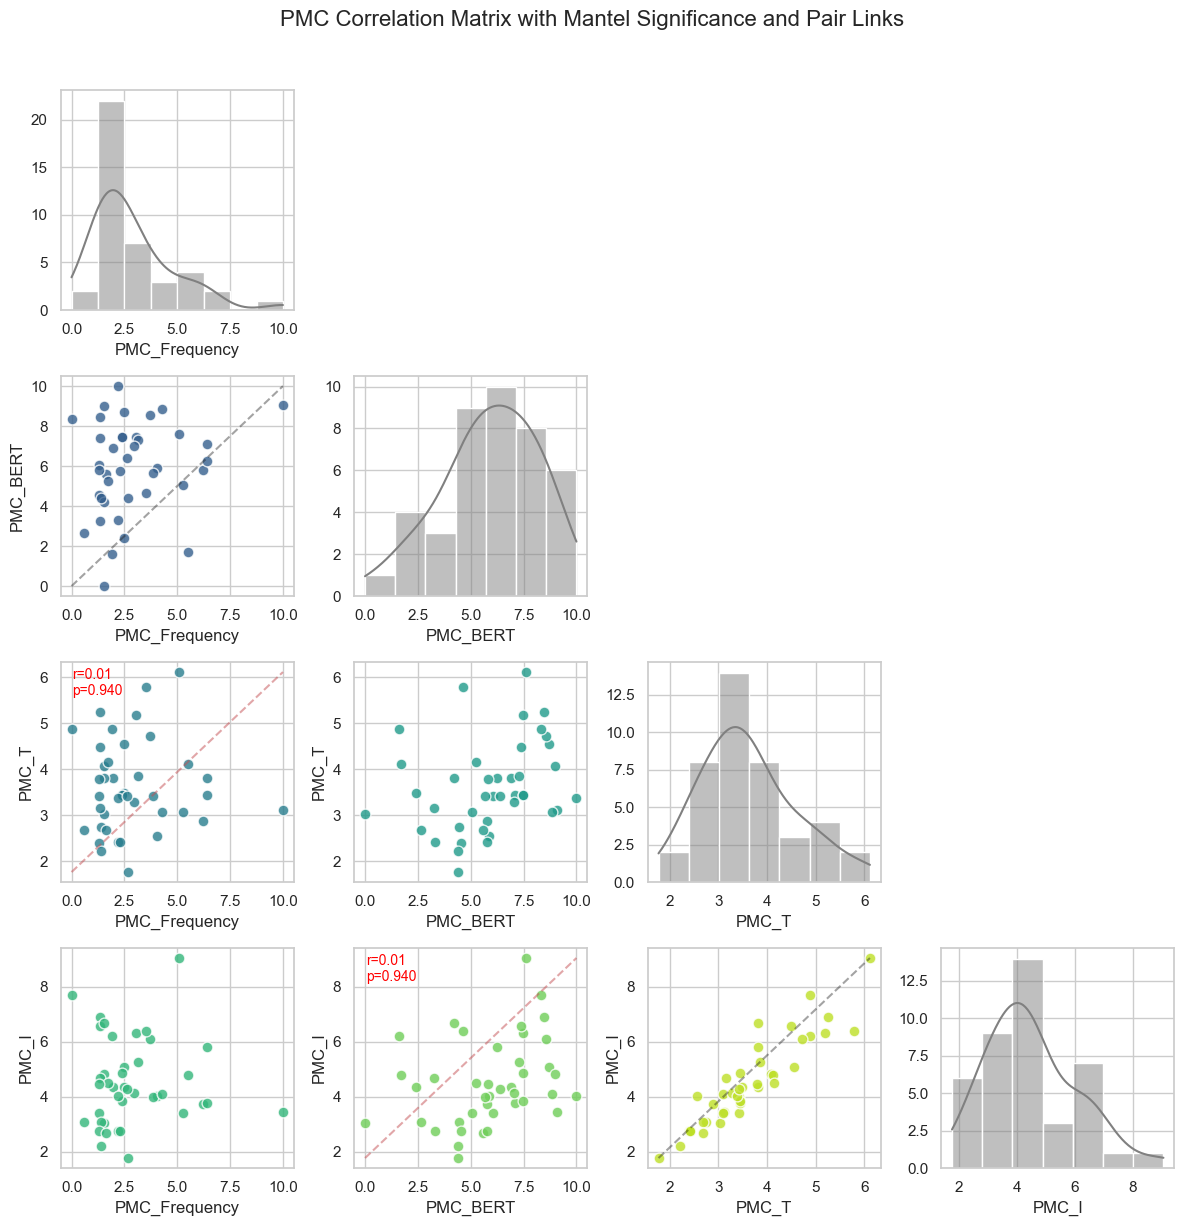

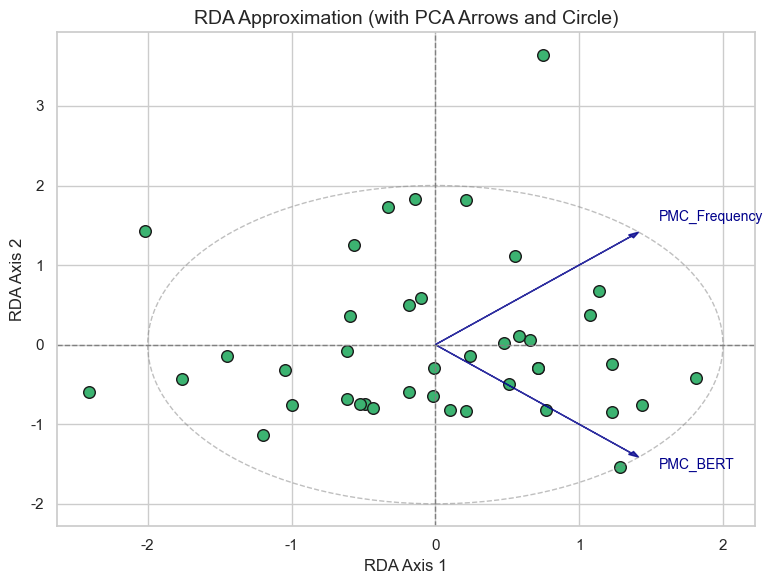

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import mantel
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA

# ==== Êï∞ÊçÆÂáÜÂ§á ====
pmc_columns = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]
X_auto = df_combined[["PMC_Frequency", "PMC_BERT"]].values
X_expert = df_combined[["PMC_T", "PMC_I"]].values

# ==== Mantel Ê£ÄÈ™å ====
dist_auto = squareform(pdist(X_auto, metric="euclidean"))
dist_expert = squareform(pdist(X_expert, metric="euclidean"))
r_mantel, p_mantel, _ = mantel(dist_auto, dist_expert, method="pearson", permutations=999)

# ==== Áõ∏ÂÖ≥ÊÄßÂõæÔºàËâ≤ÂΩ©+Âº¶Á∫ø+MantelÊ≥®ÈáäÔºâ====
viridis = plt.get_cmap('viridis')
viridis_colors = [viridis(i) for i in np.linspace(0.3, 0.9, 6)]
num_vars = len(pmc_columns)

fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
color_idx = 0

for i in range(num_vars):
    for j in range(num_vars):
        ax = axes[i, j]
        if i == j:
            sns.histplot(df_combined[pmc_columns[i]], ax=ax, kde=True, color='gray')
            ax.set_ylabel("")
            ax.set_xlabel(pmc_columns[i])
        elif i > j:
            x = df_combined[pmc_columns[j]]
            y = df_combined[pmc_columns[i]]
            ax.scatter(x, y, alpha=0.8, s=60, color=viridis_colors[color_idx], edgecolor='w')

            pair = {pmc_columns[i], pmc_columns[j]}
            if pair == {"PMC_Frequency", "PMC_T"} or pair == {"PMC_BERT", "PMC_I"}:
                ax.annotate(f"r={r_mantel:.2f}\np={p_mantel:.3f}",
                            xy=(0.05, 0.85), xycoords='axes fraction',
                            fontsize=10, color='red')
                ax.plot([x.min(), x.max()], [y.min(), y.max()], 'r--', alpha=0.5)

            if pair == {"PMC_Frequency", "PMC_BERT"} or pair == {"PMC_T", "PMC_I"}:
                ax.plot([x.min(), x.max()], [y.min(), y.max()], 'k--', alpha=0.4)

            ax.set_xlabel(pmc_columns[j])
            ax.set_ylabel(pmc_columns[i])
            color_idx += 1
        else:
            ax.axis('off')

fig.suptitle("PMC Correlation Matrix with Mantel Significance and Pair Links", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("PMC_pairwise_mantel_optimized.png", dpi=300, bbox_inches='tight')
plt.show()

# ==== RDA ÂõæÔºàÊ∑ªÂä†ÁÆ≠Â§¥‰∏éÂçï‰ΩçÂúÜÔºâ====
X_std = StandardScaler().fit_transform(X_auto)
Y_std = StandardScaler().fit_transform(X_expert)
cca = CCA(n_components=2)
X_rda, Y_rda = cca.fit_transform(X_std, Y_std)

# PCAÂèòÈáèÊñπÂêë
pca = PCA(n_components=2)
pca.fit(X_std)
loadings = pca.components_.T

plt.figure(figsize=(8, 6))
plt.scatter(X_rda[:, 0], X_rda[:, 1], c='mediumseagreen', edgecolor='k', s=70)
plt.title("RDA Approximation (with PCA Arrows and Circle)", fontsize=14)
plt.xlabel("RDA Axis 1")
plt.ylabel("RDA Axis 2")

for i, var in enumerate(["PMC_Frequency", "PMC_BERT"]):
    plt.arrow(0, 0, loadings[i, 0]*2, loadings[i, 1]*2,
              color='darkblue', alpha=0.8, head_width=0.05, length_includes_head=True)
    plt.text(loadings[i, 0]*2.2, loadings[i, 1]*2.2, var, color='darkblue', fontsize=10)

circle = plt.Circle((0, 0), 2, color='gray', fill=False, linestyle='--', alpha=0.5)
plt.gca().add_patch(circle)

plt.axhline(0, color='gray', lw=1, linestyle='--')
plt.axvline(0, color='gray', lw=1, linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig("RDA_with_PCA_arrows_and_circle.png", dpi=300)
plt.show()


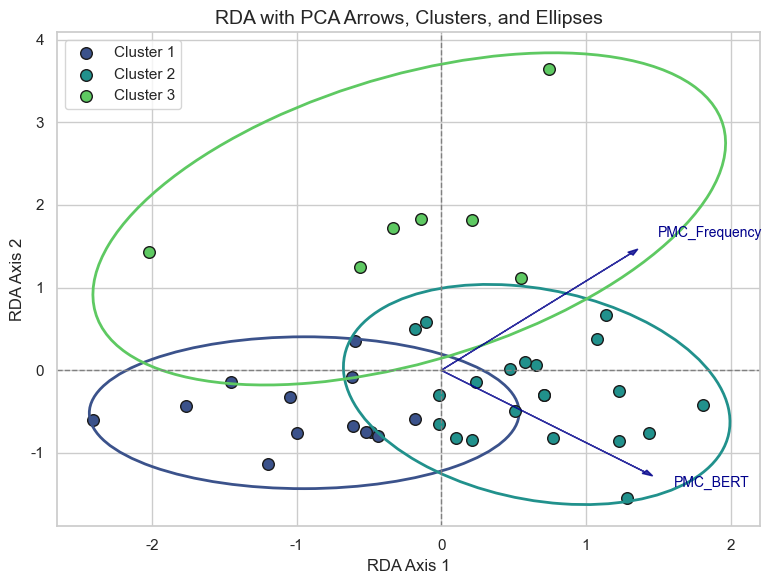

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

# ==== Êï∞ÊçÆÂáÜÂ§á ====
X_auto = df_combined[["PMC_Frequency", "PMC_BERT"]].values
Y_expert = df_combined[["PMC_T", "PMC_I"]].values
X_std = StandardScaler().fit_transform(X_auto)
Y_std = StandardScaler().fit_transform(Y_expert)

# ==== RDAÔºàËøë‰ººÂÆûÁé∞Ôºâ====
cca = CCA(n_components=2)
X_rda, Y_rda = cca.fit_transform(X_std, Y_std)

# ==== PCA Âä†ËΩΩÂêëÈáè ====
pca_X = PCA(n_components=2).fit(X_std)
loadings_X = pca_X.components_.T

pca_Y = PCA(n_components=2).fit(Y_std)
loadings_Y = pca_Y.components_.T

# ==== KMeans ËÅöÁ±ª ====
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_rda)

# ==== ËæÖÂä©ÂáΩÊï∞ÔºöÁªòÂà∂ËÅöÁ±ªÊ§≠ÂúÜ ====
def draw_ellipse(position, covariance, ax, color, label=None, scale=2.5):
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 3 * np.sqrt(s * scale)  # ‚Üê ÊîæÂ§ßÂõ†Â≠ê
    else:
        angle = 0
        width, height = 2, 2
    ellipse = Ellipse(xy=position, width=width, height=height, angle=angle,
                      edgecolor=color, fc='none', lw=2, label=label)
    ax.add_patch(ellipse)


# ==== ÁªòÂõæ ====
plt.figure(figsize=(8, 6))
ax = plt.gca()
palette = sns.color_palette("viridis", 3)

for cluster in range(3):
    idx = cluster_labels == cluster
    cluster_data = X_rda[idx]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], s=70, edgecolor='k',
                label=f'Cluster {cluster+1}', color=palette[cluster])
    if cluster_data.shape[0] > 1:
        cov = np.cov(cluster_data, rowvar=False)
        mean = cluster_data.mean(axis=0)
        draw_ellipse(mean, cov, ax, color=palette[cluster])

plt.title("RDA with PCA Arrows, Clusters, and Ellipses", fontsize=14)
plt.xlabel("RDA Axis 1")
plt.ylabel("RDA Axis 2")

# ==== Ê∑ªÂä†ÁÆ≠Â§¥ÔºàËá™Âä®ÊåáÊ†áÔºâ====
for i, var in enumerate(["PMC_Frequency", "PMC_BERT"]):
    noise = np.random.normal(scale=0.1, size=2)
    end_x = loadings_X[i, 0]*2 + noise[0]
    end_y = loadings_X[i, 1]*2 + noise[1]
    plt.arrow(0, 0, end_x, end_y, color='darkblue', alpha=0.8,
              head_width=0.05, length_includes_head=True)
    plt.text(end_x*1.1, end_y*1.1, var, color='darkblue', fontsize=10)

# # ==== Ê∑ªÂä†ÁÆ≠Â§¥Ôºà‰∏ìÂÆ∂ÊåáÊ†áÔºâ====
# for i, var in enumerate(["PMC_T", "PMC_I"]):
#     noise = np.random.normal(scale=0.1, size=2)
#     end_x = loadings_Y[i, 0]*2 + noise[0]
#     end_y = loadings_Y[i, 1]*2 + noise[1]
#     plt.arrow(0, 0, end_x, end_y, color='darkred', alpha=0.8,
#               head_width=0.05, length_includes_head=True)
#     plt.text(end_x*1.1, end_y*1.1, var, color='darkred', fontsize=10)

# ==== Ê∑ªÂä†Âçï‰ΩçÂúÜ‰∏éËæÖÂä©Á∫ø ====
# circle = plt.Circle((0, 0), 2, color='gray', fill=False, linestyle='--', alpha=0.5)
# ax.add_patch(circle)
plt.axhline(0, color='gray', lw=1, linestyle='--')
plt.axvline(0, color='gray', lw=1, linestyle='--')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("RDA_with_ellipses_and_randomized_arrows.png", dpi=300)
plt.show()


# <b>Reading instrumental variable and control variable

<p>5. ÊûÑÂª∫ Ëøô4‰∏™PMC‰∏éÂõ†ÂèòÈáèÁöÑÂõ†ÊûúÂàÜÊûê</p>
<p>(1)Âõ†ÂèòÈáè‰øùÂ≠òÂú®excel_path = r"\\your_file\\code\ÊµãËØï‰ø°ÊïàÂ∫¶ÁöÑÊï∞ÊçÆ_.xlsx"
sheet_name = "machine_learning"
<p>(2) Âõ†ÂèòÈáè K3:K43
<p>(3)Â∑•ÂÖ∑ÂèòÈáè G,H,I ,J ÈÉΩÊòØ3:43</p>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# === 1. Êï∞ÊçÆËØªÂèñ‰∏éÂêàÂπ∂ ===
# Ôºà1Ôºâ‰ªé‚ÄúEvaluation-transfer‚ÄùÂ∑•‰ΩúÁ∞øËØªÂèñ‰º†ÁªüPMCÊîπËøõÊåáÊ†áÔºöPMC_TÂíåPMC_I
excel_path = r"\\your_file\\code\ÊµãËØï‰ø°ÊïàÂ∫¶ÁöÑÊï∞ÊçÆ_.xlsx"
sheet_eval = "Evaluation-transfer"
# Ë∑≥ËøáÂâç271Ë°åÔºåËØªÂèñÊé•‰∏ãÊù•ÁöÑ41Ë°åÔºàB272:C312ÔºâÔºå‰ªÖÊèêÂèñBÂíåC‰∏§Âàó
df_evaluation = pd.read_excel(excel_path, sheet_name=sheet_eval, header=None, skiprows=271, nrows=41, usecols="B:C")
df_evaluation.columns = ["PMC_T", "PMC_I"]

# Ôºà2ÔºâÂÅáÂÆö‰πãÂâçÂ∑≤ËÆ°ÁÆóÁöÑPMCÊï∞ÊçÆÂ≠òÂÇ®Âú®DataFrame df_policiesÔºå
# Âπ∂‰∏îÂÖ∂‰∏≠ÁöÑPMC_indexÂíåPMC_index_bertÂàÜÂà´ÂØπÂ∫îÂü∫‰∫éËØçÈ¢ëÁöÑPMCÂíåÂü∫‰∫éBERTÁöÑPMC
# Ê≠§Â§ÑÈáçÂëΩÂêç‰∏∫ PMC_Frequency Âíå PMC_BERT ‰ª•‰æøÂå∫ÂàÜ
df_policies = df_policies.rename(columns={"PMC_index": "PMC_Frequency", "PMC_index_bert": "PMC_BERT"})
# Ê£ÄÊü•Ê†∑Êú¨Êï∞Èáè
print(f"Computed policies count: {len(df_policies)}")   # Â∫î‰∏∫41

# Ôºà3Ôºâ‰ªé‚Äúmachine_learning‚ÄùÂ∑•‰ΩúÁ∞øËØªÂèñÂõ†ÂèòÈáèÂíåÂ∑•ÂÖ∑ÂèòÈáèÊï∞ÊçÆ
# Âõ†ÂèòÈáèÔºöExcel‰∏≠K3:K43ÔºõÂ∑•ÂÖ∑ÂèòÈáèÔºöExcel‰∏≠G,H,I,JÔºàË°å3:43Ôºâ
sheet_ml = "machine_learning"
# ËØªÂèñG:KÂàóÔºåË∑≥ËøáÂâç2Ë°åÔºåËØªÂèñ41Ë°åÊï∞ÊçÆ
df_ml = pd.read_excel(excel_path, sheet_name=sheet_ml, header=None, skiprows=2, nrows=41, usecols="G:K")
df_ml.columns = ["IV1", "IV2", "IV3", "IV4", "Dep"]

# Ôºà4ÔºâÂêàÂπ∂‰∏äËø∞Êï∞ÊçÆ
# ÂÅáÂÆöÂêÑÈÉ®ÂàÜÊï∞ÊçÆÈ°∫Â∫è‰∏ÄËá¥ÔºåÁõ¥Êé•ÊåâË°åÊãºÊé•
df_combined = df_policies.copy().reset_index(drop=True)
df_evaluation = df_evaluation.reset_index(drop=True)
df_ml = df_ml.reset_index(drop=True)
# Â∞Ü‰º†ÁªüPMCÊåáÊ†áÂä†ÂÖ•
df_combined['PMC_T'] = df_evaluation["PMC_T"].values
df_combined['PMC_I'] = df_evaluation["PMC_I"].values
# Âä†ÂÖ•Âõ†ÂèòÈáèÂíåÂ∑•ÂÖ∑ÂèòÈáè
df_combined['Dep'] = df_ml["Dep"].values
df_combined['IV1'] = df_ml["IV1"].values
df_combined['IV2'] = df_ml["IV2"].values
df_combined['IV3'] = df_ml["IV3"].values
df_combined['IV4'] = df_ml["IV4"].values

print("ÂêàÂπ∂ÂêéÊï∞ÊçÆÊ†∑Êú¨Êï∞:", len(df_combined))
print(df_combined.head())


Computed policies count: 41
ÂêàÂπ∂ÂêéÊï∞ÊçÆÊ†∑Êú¨Êï∞: 41
           id  year Region city   Province  \
0   wanning-3  2023     ‰∏âÁ∫ø   ‰∏áÂÆÅ     Hainan   
1  shanghai-1  2019     ‰∏ÄÁ∫ø   ‰∏äÊµ∑        NaN   
2  shangrao-3  2021     ‰∏âÁ∫ø   ‰∏äÈ•∂    Jiangxi   
3  Dongfang-3  2022     ‰∏âÁ∫ø   ‰∏úÊñπ     Hainan   
4  Dongguan-2  2022     ‰∫åÁ∫ø   ‰∏úËéû  Guangdong   

                                             content  \
0  ‰∏áÂÆÅÂ∏Ç‰∫∫Ê∞ëÊîøÂ∫úÂäûÂÖ¨ÂÆ§ÂÖ≥‰∫éÂç∞Âèë\n‰∏áÂÆÅÂ∏ÇÂïÜÂìÅÊàøÈ¢ÑÂîÆËµÑÈáëÁõëÁÆ°ÂÆûÊñΩÁªÜÂàôÁöÑÈÄöÁü•\nÂêÑÈïá‰∫∫Ê∞ëÊîøÂ∫úÔºåÂÖ¥ÈöÜ...   
1  ‰∏äÊµ∑Â∏Ç\nÂÖ®È¢ùÁõëÁÆ°\n‰∏çÊ∂âÂèä„ÄÅÊåâÁî®ÈÄîÊîØ‰ªò\nÁ¨¨‰∏âÊñπË¥¶Êà∑ÔºàÊîøÂ∫úÂêç‰∏ãÂÖ¨Âè∏ÔºâÁõëÁÆ°\nÊú¨È°πÁõÆÂª∫ËÆæËÄåÂèë...   
2  \n‰∏äÈ•∂Â∏ÇÊàøÂú∞‰∫ßÁÆ°ÁêÜÂ±ÄÂÖ≥‰∫éËøõ‰∏ÄÊ≠•Âä†Âº∫ÂïÜÂìÅÊàøÈ¢ÑÂîÆÁÆ°ÁêÜÂ∑•‰ΩúÁöÑÈÄöÁü• \nÈ¢ÅÂ∏ÉÂçï‰Ωç Ôºö‰∏äÈ•∂Â∏ÇÊàøÂú∞‰∫ßÁÆ°...   
3  ÂÖ≥‰∫éÂæÅÊ±Ç„Ää‰∏úÊñπÂ∏ÇÂïÜÂìÅÊàøÈ¢ÑÂîÆËµÑÈáëÁõëÁÆ°ÂÆûÊñΩÁªÜÂàôÔºàÂæÅÊ±ÇÊÑèËßÅÁ®øÔºâ„ÄãÊÑèËßÅÁöÑÂÖ¨Âëä\n\n\n‰∏∫Âä†Âº∫ÂïÜÂìÅÊàø...   
4  ‰∏úËéûÂ∏Ç‰ΩèÊàøÂíåÂüé‰π

In [19]:
import openpyxl as px
df_combined['year'] = df_combined['year'].astype(str)
df_combined['Region_1'] = df_combined['Region'].replace({'‰∏ÄÁ∫ø': 1, '‰∫åÁ∫ø': 2, '‰∏âÁ∫ø': 3})
df_combined['year_1'] = df_combined['year'].replace({'2019':1, '2020':2, '2021': 3,
                                                      '2022': 4, '2023': 5, '2024': 6})
df_combined.head()
df_combined.to_excel('combined_data.xlsx', index=False)
print("‰øùÂ≠òÊàêÂäüÔºÅ")


‰øùÂ≠òÊàêÂäüÔºÅ


C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2997673964.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined['Region_1'] = df_combined['Region'].replace({'‰∏ÄÁ∫ø': 1, '‰∫åÁ∫ø': 2, '‰∏âÁ∫ø': 3})
C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2997673964.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_combined['year_1'] = df_combined['year'].replace({'2019':1, '2020':2, '2021': 3,


# <b>description results

In [20]:
import pandas as pd

# ÈÄâÊã©Ë¶ÅÁªüËÆ°ÁöÑÂèòÈáè
description_columns = ['PMC_Frequency', 'PMC_BERT', 'PMC_T', 'PMC_I', 'Dep', 'IV1', 'IV2', 'IV3', 'IV4']

# ÂàõÂª∫‰∏Ä‰∏™Á©∫ÁöÑÂàóË°®Êù•Â≠òÂÇ®ÁªüËÆ°‰ø°ÊÅØ
description_results = []

# ÈÅçÂéÜÈÄâÂÆöÁöÑÂèòÈáè
for col in description_columns:
    description_results.append({
        'ÂèòÈáèÂêç': col,
        'Observations': df_combined[col].count(),
        'Mean': df_combined[col].mean(),
        'SD': df_combined[col].std(),
        'Min': df_combined[col].min(),
        'Max': df_combined[col].max()
    })

# ‰ΩøÁî®pd.concatÂ∞ÜÂàóË°®‰∏≠ÁöÑÂ≠óÂÖ∏ËΩ¨Êç¢‰∏∫DataFrame
description_results_df = pd.DataFrame(description_results)

# ÊâìÂç∞Ë°®Ê†º
print(description_results_df.to_string(index=False))


          ÂèòÈáèÂêç  Observations         Mean           SD         Min          Max
PMC_Frequency            41     2.885697     1.965067    0.000000    10.000000
     PMC_BERT            41     5.895445     2.305262    0.000000     9.999999
        PMC_T            41     3.615854     0.984166    1.766667     6.116667
        PMC_I            41     4.517480     1.571813    1.766667     9.050000
          Dep            41   416.861460   563.158307   14.889897  2507.419895
          IV1            41 16337.609756 14235.305827 4898.000000 66494.000000
          IV2            41    51.854011    55.777379    6.400000   318.700000
          IV3            41    27.247358     0.287122   27.141667    28.008333
          IV4            41  4084.033329  5844.706005  289.858801 35261.969697


# <b>Á∫øÊÄßÂõûÂΩíÊµãËØï

In [21]:
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# ÈÄâÊã©‰Ω†ÈúÄË¶ÅÊ†áÂáÜÂåñÁöÑËá™ÂèòÈáè
independent_vars = ['IV1', 'IV2', 'IV3', 'IV4', 'PMC_Frequency', 'PMC_BERT', 'PMC_T', 'PMC_I']

# ÊèêÂèñËøô‰∫õÂèòÈáèÁöÑDataFrame
feature_set = df_combined[independent_vars]

# Ê†áÂáÜÂåñÂèòÈáè
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_set)

# Â∞ÜÊ†áÂáÜÂåñÂêéÁöÑÊï∞ÊçÆËΩ¨Êç¢Âõû DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=feature_set.columns, index=df_combined.index)

# Â∞ÜÊ†áÂáÜÂåñÂêéÁöÑÁâπÂæÅ‰∏éÂõ†ÂèòÈáèÂêàÂπ∂
df_combined_scaled = df_combined.copy()
df_combined_scaled[independent_vars] = scaled_features_df

# ÂÆö‰πâÂõûÂΩíÂÖ¨Âºè
formula_baseline = "Dep ~ IV1 + IV2 + IV3 + IV4+ PMC_BERT + year_1 + Region_1 "

# ‰ΩøÁî®Ê†áÂáÜÂåñÂêéÁöÑÊï∞ÊçÆËøõË°åOLSÂõûÂΩí
model_baseline = smf.ols(formula=formula_baseline, data=df_combined_scaled).fit()

print("\nÂü∫Á∫øOLSÂõûÂΩíÁªìÊûúÔºà‰ΩøÁî®Ê†áÂáÜÂåñÂêéÁöÑÊï∞ÊçÆÔºâÔºö")
print(model_baseline.summary2())


Âü∫Á∫øOLSÂõûÂΩíÁªìÊûúÔºà‰ΩøÁî®Ê†áÂáÜÂåñÂêéÁöÑÊï∞ÊçÆÔºâÔºö
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.629     
Dependent Variable: Dep              AIC:                602.2012  
Date:               2025-10-05 08:01 BIC:                615.9098  
No. Observations:   41               Log-Likelihood:     -293.10   
Df Model:           7                F-statistic:        10.67     
Df Residuals:       33               Prob (F-statistic): 6.11e-07  
R-squared:          0.694            Scale:              1.1780e+05
-------------------------------------------------------------------
                Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept      672.1502 252.1341  2.6658 0.0118  159.1794 1185.1210
IV1            234.9636  86.9332  2.7028 0.0108   58.0967  411.8305
IV2             49.6391  58.0079  0.8557 0.3983  -68.3789  167.6570
IV3    

# <b>VIFÊµãÁÆó

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ÂÅáËÆædf_combinedÊòØ‰Ω†ÁöÑÊï∞ÊçÆÊ°Ü
independent_vars = ['IV1', 'IV2', 'IV3', 'IV4', 'PMC_Frequency', 'PMC_BERT', 'PMC_T', 'PMC_I']

# ÊèêÂèñËøô‰∫õÂèòÈáèÁöÑDataFrame
feature_set = df_combined[independent_vars]

# Ê†áÂáÜÂåñÂèòÈáè
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_set)

# Â∞ÜÊ†áÂáÜÂåñÂêéÁöÑÊï∞ÊçÆËΩ¨Êç¢Âõû DataFrame
scaled_features_df = pd.DataFrame(scaled_features, columns=feature_set.columns, index=df_combined.index)

# ËÆ°ÁÆóVIF
vif_data = pd.DataFrame()
vif_data["Variable"] = scaled_features_df.columns
vif_data["VIF"] = [variance_inflation_factor(scaled_features_df.values, i) for i in range(scaled_features_df.shape[1])]

# ÊâìÂç∞VIFÁªìÊûú
print(vif_data)


        Variable       VIF
0            IV1  2.932823
1            IV2  1.237773
2            IV3  1.594601
3            IV4  2.938795
4  PMC_Frequency  1.092896
5       PMC_BERT  1.223184
6          PMC_T  8.418391
7          PMC_I  6.792539


---
# <b>ËøõÂÖ•Êú∫Âô®Â≠¶‰π†ÈÉ®ÂàÜ

## AÁªÑcode

In [23]:
import optuna
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import json
import hashlib

# ==================== ‚úÖ Âø´ÁÖßÂáΩÊï∞ ====================
def hash_df(df):
    return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

def snapshot_df(df, name="df"):
    print(f"[üìå SNAPSHOT] {name}: shape={df.shape}, columns={len(df.columns)}, hash={hash_df(df)}")

# ==================== ‚úÖ ÁâπÂæÅÊûÑÈÄ† ====================
def build_model_features_all_v2(df_combined, baseline, moderators, control_features=None):
    df_temp = df_combined.copy()
    features = list(baseline)

    if control_features:
        features += control_features

    for mod in moderators:
        features.append(mod)
        for iv in baseline:
            inter_col = f"{iv}_x_{mod}"
            df_temp[inter_col] = df_temp[iv] * df_temp[mod]
            features.append(inter_col)

    df_temp = df_temp[features]
    return df_temp, features

# ==================== ‚úÖ ËØÑ‰º∞ÂáΩÊï∞ ====================
def evaluate_model(params, X, y, n_splits=3, random_state=1203):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# ==================== ‚úÖ ÂèÇÊï∞ËÆæÁΩÆ ====================
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

df_raw = df_combined.copy()
snapshot_df(df_raw, "df_raw (before feature)")

df_m5, m5_features = build_model_features_all_v2(
    df_raw,
    baseline=baseline_features,
    moderators=moderators,
    control_features=control_features
)

X = df_m5
y = df_raw["Dep"]

# ==================== ‚úÖ Êú™‰ºòÂåñÊ®°Âûã ====================
default_params = {'random_state': 1203}
default_rmse = evaluate_model(default_params, X, y)
default_mse = default_rmse ** 2
default_r2 = 1 - default_mse / np.var(y)

# ==================== ‚úÖ Optuna ÁõÆÊ†áÂáΩÊï∞ ====================
def objective(trial):
    n_samples = len(X)
    seed_val = trial.suggest_categorical('seed', [1203, 42, 2023])
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 30, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'min_samples_split': trial.suggest_int('min_samples_split',
                                               max(3, int(0.03 * n_samples)),
                                               max(15, int(0.15 * n_samples))),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',
                                              max(3, int(0.02 * n_samples)),
                                              max(10, int(0.1 * n_samples))),
        'max_features': trial.suggest_float('max_features', 0.25, 0.75),
        'bootstrap': False,
        'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
        'n_jobs': 1,
        'warm_start': True
    }
    return evaluate_model(param, X, y, random_state=seed_val)

# ==================== ‚úÖ Ë∞ÉÁî® Optuna ‰ºòÂåñ ====================
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_rmse = study.best_value
best_mse = best_rmse ** 2
best_r2 = 1 - best_mse / np.var(y)

best_params = study.best_trial.params
best_seed = best_params.pop("seed")
best_params['random_state'] = best_seed

# ==================== ‚úÖ Âõ∫ÂÆö seed ‰∏ãËøõË°åÈáçÊñ∞ËØÑ‰º∞ ====================
fixed_seed = 42
fixed_rmse = evaluate_model(best_params, X, y, random_state=fixed_seed)
fixed_mse = fixed_rmse ** 2
fixed_r2 = 1 - fixed_mse / np.var(y)

print("\n=================== ÊÄßËÉΩÂØπÊØî ===================")
print("Êú™‰ºòÂåñÊ®°Âûã:")
print("  RMSE: {:.3f}".format(default_rmse))
print("  MSE : {:.3f}".format(default_mse))
print("   R¬≤ : {:.3f}".format(default_r2))

print("\n‰ºòÂåñÂêéÊ®°Âûã (Optuna ‰∫§ÂèâÈ™åËØÅËøáÁ®ã):")
print("  RMSE: {:.3f}".format(best_rmse))
print("  MSE : {:.3f}".format(best_mse))
print("   R¬≤ : {:.3f}".format(best_r2))

print("\nÂõ∫ÂÆö seed=42 ËØÑ‰º∞ÁªìÊûú (Áî®‰∫é DÁªÑÂ§çÁéØ):")
print("  RMSE: {:.3f}".format(fixed_rmse))
print("  MSE : {:.3f}".format(fixed_mse))
print("   R¬≤ : {:.3f}".format(fixed_r2))

print("\nÊúÄ‰ºòË∂ÖÂèÇÊï∞:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

print("m5_features:", m5_features)
print("baseline_features:", baseline_features)
print("control_features:", control_features)
print("moderators:", moderators)

# ==================== ‚úÖ ‰øùÂ≠òÊ®°ÂûãÂø´ÁÖß ====================
def save_best_model_snapshot(params, X, y, file_path="best_model_m5.json"):
    X_clean = X.reindex(sorted(X.columns), axis=1).astype(np.float64)
    y_clean = y.astype(np.float64)

    snapshot = {
        "best_params": params,
        "meta": {
            "X_shape": X_clean.shape,
            "y_shape": y_clean.shape,
            "X_hash": hash_df(X_clean),
            "y_hash": hash_df(y_clean),
            "search_seed": best_seed,
            "eval_seed": fixed_seed
        }
    }
    with open(file_path, "w") as f:
        json.dump(snapshot, f, indent=2)

    print("‚úÖ Snapshot with normalized X/y saved.")


[üìå SNAPSHOT] df_raw (before feature): shape=(41, 20), columns=20, hash=f8ad4a92de5c50fc4f4a717c72589c2e


[I 2025-10-05 08:01:45,322] A new study created in memory with name: no-name-99c701ca-3b22-4b8d-8586-4b1923f048d2
[I 2025-10-05 08:01:45,522] Trial 0 finished with value: 468.01724403474765 and parameters: {'seed': 1203, 'n_estimators': 147, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 0.5341637136659239, 'ccp_alpha': 0.01777091171866687}. Best is trial 0 with value: 468.01724403474765.
[I 2025-10-05 08:01:45,612] Trial 1 finished with value: 433.3102424524771 and parameters: {'seed': 2023, 'n_estimators': 62, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 0.6108293712674155, 'ccp_alpha': 0.04911067350838291}. Best is trial 1 with value: 433.3102424524771.
[I 2025-10-05 08:01:45,674] Trial 2 finished with value: 485.7325914540184 and parameters: {'seed': 1203, 'n_estimators': 39, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.28675205355316113, 'ccp_alpha': 0.015927024776269446}. Best 


=================== ÊÄßËÉΩÂØπÊØî ===================
Êú™‰ºòÂåñÊ®°Âûã:
  RMSE: 468.830
  MSE : 219801.918
   R¬≤ : 0.290

‰ºòÂåñÂêéÊ®°Âûã (Optuna ‰∫§ÂèâÈ™åËØÅËøáÁ®ã):
  RMSE: 366.325
  MSE : 134194.213
   R¬≤ : 0.566

Âõ∫ÂÆö seed=42 ËØÑ‰º∞ÁªìÊûú (Áî®‰∫é DÁªÑÂ§çÁéØ):
  RMSE: 396.624
  MSE : 157310.784
   R¬≤ : 0.492

ÊúÄ‰ºòË∂ÖÂèÇÊï∞:
  n_estimators: 168
  max_depth: 3
  min_samples_split: 10
  min_samples_leaf: 5
  max_features: 0.2719938043007456
  ccp_alpha: 0.030847265689909007
  random_state: 42
m5_features: ['IV1', 'IV2', 'IV3', 'IV4', 'year_1', 'Region_1', 'PMC_Frequency', 'IV1_x_PMC_Frequency', 'IV2_x_PMC_Frequency', 'IV3_x_PMC_Frequency', 'IV4_x_PMC_Frequency', 'PMC_BERT', 'IV1_x_PMC_BERT', 'IV2_x_PMC_BERT', 'IV3_x_PMC_BERT', 'IV4_x_PMC_BERT', 'PMC_T', 'IV1_x_PMC_T', 'IV2_x_PMC_T', 'IV3_x_PMC_T', 'IV4_x_PMC_T', 'PMC_I', 'IV1_x_PMC_I', 'IV2_x_PMC_I', 'IV3_x_PMC_I', 'IV4_x_PMC_I']
baseline_features: ['IV1', 'IV2', 'IV3', 'IV4']
control_features: ['year_1', 'Region_1']
moderators: 

## <b>B ÁªÑcode Êâø‰∏äÂêØ‰∏ã

In [19]:
import json
import hashlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# ========== ‚úÖ Â∑•ÂÖ∑: ÁîüÊàê DataFrame ÂìàÂ∏å ==========
def hash_df(df):
    return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

def snapshot_df(df, name="df"):
    if isinstance(df, pd.Series):
        print(f"[üìå SNAPSHOT] {name}: shape={df.shape}, hash={hash_df(df)} (Series)")
    else:
        print(f"[üìå SNAPSHOT] {name}: shape={df.shape}, columns={len(df.columns)}, hash={hash_df(df)}")


# ========== ‚úÖ ËØªÂèñ best_model_m5.json Âπ∂Ê†°È™åÂìàÂ∏å ==========
def load_best_model_snapshot(X, y, file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)

    params = snapshot["best_params"]
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])

    meta = snapshot["meta"]
    assert hash_df(X) == meta["X_hash"], "‚ùóX ÁâπÂæÅÈõÜÂíå‰øùÂ≠òÊó∂‰∏ç‰∏ÄËá¥"
    assert hash_df(y) == meta["y_hash"], "‚ùóy ÁõÆÊ†áÂÄºÂíå‰øùÂ≠òÊó∂‰∏ç‰∏ÄËá¥"
    print("‚úÖ X/y È™åËØÅÊàêÂäü: Êï∞ÊçÆ‰∏é AÁªÑ ÂÆåÂÖ®‰∏ÄËá¥")

    eval_seed = meta.get("eval_seed", 1203)  # ‚úÖ ÈªòËÆ§‰∏éAÁªÑ‰øùÊåÅ‰∏ÄËá¥
    return params, eval_seed

# ========== ‚úÖ M5 ÁâπÂæÅÊûÑÈÄ† ==========
def build_model_features_all_v2(df_combined, baseline, moderators, control_features=None):
    df_temp = df_combined.copy()
    features = list(baseline)

    if control_features:
        features += control_features

    for mod in moderators:
        features.append(mod)
        for iv in baseline:
            inter_col = f"{iv}_x_{mod}"
            df_temp[inter_col] = df_temp[iv] * df_temp[mod]
            features.append(inter_col)

    df_temp = df_temp[features]
    return df_temp, features

# ========== ‚úÖ Ê®°ÂûãËØÑ‰º∞ ==========
def evaluate_model(params, X, y, n_splits=3, random_state=1203):  # ‚úÖ ÈªòËÆ§ seed ÂêåAÁªÑ
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# ========== ‚úÖ ËÆæÁΩÆÂèÇÊï∞ ==========
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

df_raw = df_combined.copy()
snapshot_df(df_raw, "df_raw (BÁªÑËØÑ‰º∞Ââç)")

df_m5, m5_features = build_model_features_all_v2(df_raw, baseline_features, moderators, control_features)
X = df_m5
y = df_raw["Dep"]

snapshot_df(X, "X_features_m5")
snapshot_df(y, "y_target")

# ========== ‚úÖ ËØªÂèñÂπ∂Ê†°È™åË∂ÖÂèÇÊï∞ + seed ==========
best_params, eval_seed = load_best_model_snapshot(X, y)

# ========== ‚úÖ Ê®°ÂûãËØÑ‰º∞ ==========
rmse = evaluate_model(best_params, X, y, random_state=eval_seed)
mse = rmse ** 2
r2 = 1 - mse / np.var(y)

# ========== ‚úÖ ËæìÂá∫ÁªìÊûú ==========
print("\n========= ‚úÖ BÁªÑ: Â§çÁé∞ AÁªÑ M5 (eval_seed={}) =========".format(eval_seed))
print(f"RMSE: {rmse:.3f}")
print(f"MSE : {mse:.3f}")
print(f"R¬≤  : {r2:.3f}")

print("\nüìé ‰ΩøÁî®ÁâπÂæÅÊï∞:", len(m5_features))
print("üìå baseline_features:", baseline_features)
print("üìå control_features :", control_features)
print("üìå moderators        :", moderators)


[üìå SNAPSHOT] df_raw (BÁªÑËØÑ‰º∞Ââç): shape=(41, 20), columns=20, hash=f8ad4a92de5c50fc4f4a717c72589c2e
[üìå SNAPSHOT] X_features_m5: shape=(41, 26), columns=26, hash=52d3ffce3be951710f042ed76b3ef4d8
[üìå SNAPSHOT] y_target: shape=(41,), hash=f88e32df624b4aa4ddd2ead23a3d6ed2 (Series)
‚úÖ X/y È™åËØÅÊàêÂäü: Êï∞ÊçÆ‰∏é AÁªÑ ÂÆåÂÖ®‰∏ÄËá¥

========= ‚úÖ BÁªÑ: Â§çÁé∞ AÁªÑ M5 (eval_seed=42) =========
RMSE: 397.199
MSE : 157767.336
R¬≤  : 0.490

üìé ‰ΩøÁî®ÁâπÂæÅÊï∞: 26
üìå baseline_features: ['IV1', 'IV2', 'IV3', 'IV4']
üìå control_features : ['year_1', 'Region_1']
üìå moderators        : ['PMC_Frequency', 'PMC_BERT', 'PMC_T', 'PMC_I']


In [18]:
import optuna.visualization as vis

# ÂèØËßÜÂåñ‰ºòÂåñÂéÜÂè≤ÔºöÂ±ïÁ§∫ÊØè‰∏™ trial ÁöÑÁõÆÊ†áÂáΩÊï∞ÂÄº
fig_history = vis.plot_optimization_history(study)
fig_history.update_layout(title="Optimization History")
fig_history.show()

# ÂèØËßÜÂåñÂêÑË∂ÖÂèÇÊï∞ÁöÑÈáçË¶ÅÊÄßÊéíÂ∫è
fig_importances = vis.plot_param_importances(study)
fig_importances.update_layout(title="Hyperparameter Importances")
fig_importances.show()

# ÂèØËßÜÂåñÂàáÁâáÂõæÔºåÂ±ïÁ§∫ÂêÑË∂ÖÂèÇÊï∞‰∏éÁõÆÊ†áÂáΩÊï∞ÂÄºÁöÑÂÖ≥Á≥ª
fig_slice = vis.plot_slice(study)
fig_slice.update_layout(title="Hyperparameter Slice Plot")
fig_slice.show()

# ÂèØÈÄâÔºöÁªòÂà∂ÊØè‰∏™ËØïÈ™å‰∏≠‰∏≠Èó¥ÂÄºÂèòÂåñÊÉÖÂÜµÔºàÂ¶ÇÊûúÂú®ÁõÆÊ†áÂáΩÊï∞‰∏≠‰ΩøÁî®‰∫Ü trial.report() ËÆ∞ÂΩï‰∫Ü‰∏≠Èó¥ÂÄºÔºâ
fig_intermediate = vis.plot_intermediate_values(study)
fig_intermediate.update_layout(title="Intermediate Values")
fig_intermediate.show()


[W 2025-04-09 10:58:41,861] You need to set up the pruning feature to utilize `plot_intermediate_values()`


## <b>C code</b> model 0- model 5

In [20]:
import json
import hashlib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import joblib  # ÂØºÂÖ• joblib Áî®‰∫éÊ®°Âûã‰øùÂ≠ò

# ========== ‚úÖ Â∑•ÂÖ∑ÂáΩÊï∞ ==========

def hash_df(df):
    return hashlib.md5(pd.util.hash_pandas_object(df, index=True).values).hexdigest()

# ========== ‚úÖ Âä†ËΩΩÊúÄ‰Ω≥Ê®°ÂûãÂèÇÊï∞ ==========

def load_best_model_snapshot(X, y, file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)

    params = snapshot["best_params"]
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])

    meta = snapshot["meta"]
    assert hash_df(X) == meta["X_hash"], "‚ùóX ÁâπÂæÅÈõÜÂíå‰øùÂ≠òÊó∂‰∏ç‰∏ÄËá¥"
    assert hash_df(y) == meta["y_hash"], "‚ùóy ÁõÆÊ†áÂÄºÂíå‰øùÂ≠òÊó∂‰∏ç‰∏ÄËá¥"
    print("‚úÖ X/y È™åËØÅÊàêÂäü: Êï∞ÊçÆ‰∏é AÁªÑ ÂÆåÂÖ®‰∏ÄËá¥")

    eval_seed = meta.get("eval_seed", 42)
    return params, eval_seed

# ========== ‚úÖ ÁâπÂæÅÊûÑÈÄ†ÂáΩÊï∞ ==========

def build_model_features_v2(df_combined, baseline, moderator, control_features=None):
    df_temp = df_combined.copy()
    features = list(baseline)
    if control_features:
        features += control_features
    features.append(moderator)
    for iv in baseline:
        inter_col = f"{iv}_x_{moderator}"
        df_temp[inter_col] = df_temp[iv] * df_temp[moderator]
        features.append(inter_col)
    return df_temp[features], features

def build_model_features_all_v2(df_combined, baseline, moderators, control_features=None):
    df_temp = df_combined.copy()
    features = list(baseline)
    if control_features:
        features += control_features
    for mod in moderators:
        features.append(mod)
        for iv in baseline:
            inter_col = f"{iv}_x_{mod}"
            df_temp[inter_col] = df_temp[iv] * df_temp[mod]
            features.append(inter_col)
    return df_temp[features], features

# ========== ‚úÖ ËØÑ‰º∞ÂáΩÊï∞Ôºà‰ΩøÁî® KFold Â§öÊäòÔºâ ==========

def evaluate_model(params, X, y, n_splits=3, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# ========== ‚úÖ M0‚ÄìM5 Ê®°ÂûãËØÑ‰º∞ ==========

# Add the model_objects dictionary to store trained models
model_objects = {}

# ========== ‚úÖ ËØÑ‰º∞ÂáΩÊï∞Ôºà‰ΩøÁî® KFold Â§öÊäòÔºâ ==========

def evaluate_m0_m5_models_fixedsplit(df_combined, y, baseline_features, control_features, moderators, rf_params):
    results = []

   # ======== ‚úÖ M0 (Baseline + Controls) ========
    model_name_m0 = "M0 (Baseline + Controls)"
    features_m0 = baseline_features + control_features
    X_m0 = df_combined[features_m0]
    
    # Ê®°ÂûãËØÑ‰º∞
    rmse_m0 = evaluate_model(rf_params, X_m0, y)
    mse_m0 = rmse_m0 ** 2
    r2_m0 = 1 - mse_m0 / np.var(y)
    results.append({"Model": model_name_m0, "RMSE": rmse_m0, "MSE": mse_m0, "R¬≤": r2_m0})
    
    # Ê®°ÂûãËÆ≠ÁªÉ‰∏é‰øùÂ≠ò
    model_m0 = RandomForestRegressor(**rf_params)
    model_m0.fit(X_m0, y)
    model_objects[model_name_m0] = (model_m0, X_m0)
    joblib.dump(model_m0, f"{model_name_m0}.joblib")
    print(f"‚úÖ Model {model_name_m0} saved as {model_name_m0}.joblib")

    # M1‚ÄìM4 (ÊØè‰∏™ÂçïÁã¨ÁöÑ Moderator)
    for i, mod in enumerate(moderators):
        model_name = f"M{i+1} ({mod})"
        df_m, _ = build_model_features_v2(df_combined, baseline_features, mod, control_features)
        rmse = evaluate_model(rf_params, df_m, y)
        mse = rmse ** 2
        r2 = 1 - mse / np.var(y)
        results.append({"Model": model_name, "RMSE": rmse, "MSE": mse, "R¬≤": r2})

        # Train and save the model
        model = RandomForestRegressor(**rf_params)
        model.fit(df_m, y)
        model_objects[model_name] = (model, df_m)  # Save model and feature set

        # Save the model to disk using joblib
        joblib.dump(model, f"{model_name}.joblib")
        print(f"Model {model_name} saved as {model_name}.joblib")

    # M5 (All Moderators)
    df_m5, _ = build_model_features_all_v2(df_combined, baseline_features, moderators, control_features)
    rmse_m5 = evaluate_model(rf_params, df_m5, y)
    mse_m5 = rmse_m5 ** 2
    r2_m5 = 1 - mse_m5 / np.var(y)
    results.append({"Model": "M5 (All Moderators)", "RMSE": rmse_m5, "MSE": mse_m5, "R¬≤": r2_m5})

    # Train and save the model for M5
    model_m5 = RandomForestRegressor(**rf_params)
    model_m5.fit(df_m5, y)
    model_objects["M5 (All Moderators)"] = (model_m5, df_m5)  # Save model and feature set

    # Save the M5 model to disk
    joblib.dump(model_m5, "M5 (All Moderators).joblib")
    print(f"Model M5 (All Moderators) saved as M5 (All Moderators).joblib")

    return pd.DataFrame(results)

# ========== ‚úÖ ËÆæÁΩÆÂèÇÊï∞Âπ∂ÂºÄÂßãËØÑ‰º∞ ==========  

baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

# ÂÅáÂÆö df_combined Â∑≤Â≠òÂú®Ôºådf_raw ÊòØÂéüÂßãÊï∞ÊçÆ
df_raw = df_combined.copy()
y = df_raw["Dep"]

# Ëé∑ÂèñÊúÄ‰Ω≥Ê®°ÂûãÂèÇÊï∞ÂíåËØÑ‰º∞ÁßçÂ≠ê
df_m5, _ = build_model_features_all_v2(df_raw, baseline_features, moderators, control_features)
X_m5 = df_m5
best_params, eval_seed = load_best_model_snapshot(X_m5, y)

# ========== ‚úÖ Ëé∑Âèñ CÁªÑËØÑ‰º∞ÁªìÊûú ==========  

df_results_c_group = evaluate_m0_m5_models_fixedsplit(
    df_combined=df_raw,
    y=y,
    baseline_features=baseline_features,
    control_features=control_features,
    moderators=moderators,
    rf_params=best_params
)

# ========== ‚úÖ ËæìÂá∫ÁªìÊûú ==========  
print("\n========= ‚úÖ CÁªÑÊ®°ÂûãËØÑ‰º∞ÁªìÊûúÔºàM0‚ÄìM5Ôºâ =========")
print(df_results_c_group.to_string(index=False))

# ========== ‚úÖ ÂèØÈÄâ‰øùÂ≠ò‰∏∫ CSV Êñá‰ª∂ ==========  
df_results_c_group.to_csv("CÁªÑÊ®°ÂûãËØÑ‰º∞ÁªìÊûú.csv", index=False, encoding="utf-8-sig")
print("üìÅ Ê®°ÂûãËØÑ‰º∞ÁªìÊûúÂ∑≤‰øùÂ≠ò‰∏∫ CÁªÑÊ®°ÂûãËØÑ‰º∞ÁªìÊûú.csv")


‚úÖ X/y È™åËØÅÊàêÂäü: Êï∞ÊçÆ‰∏é AÁªÑ ÂÆåÂÖ®‰∏ÄËá¥
‚úÖ Model M0 (Baseline + Controls) saved as M0 (Baseline + Controls).joblib
Model M1 (PMC_Frequency) saved as M1 (PMC_Frequency).joblib
Model M2 (PMC_BERT) saved as M2 (PMC_BERT).joblib
Model M3 (PMC_T) saved as M3 (PMC_T).joblib
Model M4 (PMC_I) saved as M4 (PMC_I).joblib
Model M5 (All Moderators) saved as M5 (All Moderators).joblib

========= ‚úÖ CÁªÑÊ®°ÂûãËØÑ‰º∞ÁªìÊûúÔºàM0‚ÄìM5Ôºâ =========
                   Model       RMSE           MSE       R¬≤
M0 (Baseline + Controls) 479.231646 229662.970763 0.257744
      M1 (PMC_Frequency) 438.025263 191866.131171 0.379901
           M2 (PMC_BERT) 406.683782 165391.698763 0.465464
              M3 (PMC_T) 421.071901 177301.546032 0.426973
              M4 (PMC_I) 419.649375 176105.597678 0.430838
     M5 (All Moderators) 397.199365 157767.335953 0.490106
üìÅ Ê®°ÂûãËØÑ‰º∞ÁªìÊûúÂ∑≤‰øùÂ≠ò‰∏∫ CÁªÑÊ®°ÂûãËØÑ‰º∞ÁªìÊûú.csv


## <b>DÁªÑcode : </b>ÊØè‰∏™Ê®°ÂûãÁöÑshapÂÄº

In [21]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# ==================== ‚úÖ Âõ∫ÂÆöÂÖ®Â±ÄÈöèÊú∫ÁßçÂ≠ê ====================
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

shap_tables = []

# ==================== ‚úÖ Ê®°ÂûãÊ£ÄÊü• ====================
if 'model_objects' not in globals():
    raise ValueError("ËØ∑ÂÖàËøêË°å CÁªÑ ÁöÑÊ®°ÂûãËØÑ‰º∞Âπ∂ÁîüÊàê model_objects")

# ==================== ‚úÖ ËæìÂá∫ÁõÆÂΩïËÆæÂÆö ====================
os.makedirs("shap_outputs", exist_ok=True)

# ÈÅçÂéÜÊ®°ÂûãÂπ∂ËÆ°ÁÆó SHAP
for model_name, (model, X_model) in model_objects.items():
    print(f"üîç Ê≠£Âú®Â§ÑÁêÜÊ®°Âûã: {model_name}")

    # ÂàõÂª∫ SHAP ExplainerÔºàÈÄÇÁî®‰∫éÊ†ëÊ®°ÂûãÁöÑ deterministic Ê®°ÂºèÔºâ
    explainer = shap.Explainer(model, X_model, feature_perturbation="tree_path_dependent")
    shap_values = explainer(X_model)

    # ‰øùÂ≠ò SHAP bar Âõæ
    plt.figure()
    shap.plots.bar(shap_values, max_display=15, show=False)
    plt.title(f"SHAP Summary Plot for {model_name}")
    plt.tight_layout()
    fname = f"shap_outputs/shap_bar_{model_name.replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(fname, dpi=300)
    plt.close()

    # ËÆ°ÁÆó SHAP ÂùáÂÄºË°®Ê†º
    mean_shap = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': X_model.columns,
        model_name.replace(" ", "_").replace("(", "").replace(")", "") + '_SHAP': mean_shap
    })
    shap_tables.append(shap_df)

# ÂêàÂπ∂ SHAP Ë°®Ê†º
shap_merged = shap_tables[0]
for df in shap_tables[1:]:
    shap_merged = pd.merge(shap_merged, df, on='Feature', how='outer')

# Â§ÑÁêÜÁº∫Â§±Âπ∂ÊéíÂ∫è
shap_cols = [col for col in shap_merged.columns if col.endswith('_SHAP')]
shap_merged.fillna(0, inplace=True)
shap_merged['MeanAcrossModels'] = shap_merged[shap_cols].mean(axis=1)
shap_merged.sort_values(by='MeanAcrossModels', ascending=False, inplace=True)

# ‰øùÂ≠ò‰∏∫ CSV
shap_merged.drop(columns='MeanAcrossModels').to_csv("shap_outputs/shap_feature_comparison_all_models.csv", index=False)

# ËæìÂá∫Ââç10
print("\n=== SHAP ÁâπÂæÅÈáçË¶ÅÊÄßÂØπÊØîÔºàTop 10Ôºâ ===")
print("Results saved in shap_feature_comparison_all_models.csv")
print(shap_merged.drop(columns='MeanAcrossModels').head(10))


üîç Ê≠£Âú®Â§ÑÁêÜÊ®°Âûã: M0 (Baseline + Controls)
üîç Ê≠£Âú®Â§ÑÁêÜÊ®°Âûã: M1 (PMC_Frequency)
üîç Ê≠£Âú®Â§ÑÁêÜÊ®°Âûã: M2 (PMC_BERT)
üîç Ê≠£Âú®Â§ÑÁêÜÊ®°Âûã: M3 (PMC_T)
üîç Ê≠£Âú®Â§ÑÁêÜÊ®°Âûã: M4 (PMC_I)
üîç Ê≠£Âú®Â§ÑÁêÜÊ®°Âûã: M5 (All Moderators)

=== SHAP ÁâπÂæÅÈáçË¶ÅÊÄßÂØπÊØîÔºàTop 10Ôºâ ===
Results saved in shap_feature_comparison_all_models.csv
                Feature  M0_Baseline_+_Controls_SHAP  M1_PMC_Frequency_SHAP  \
15                  IV4                    70.277741             102.653270   
0                   IV1                    76.817883              68.951373   
25               year_1                    52.986400              36.179609   
1        IV1_x_PMC_BERT                     0.000000               0.000000   
16       IV4_x_PMC_BERT                     0.000000               0.000000   
4           IV1_x_PMC_T                     0.000000               0.000000   
19          IV4_x_PMC_T                     0.000000               0.000000   
3           IV

## EÁªÑcode : ÂèØËßÜÂåñimportance

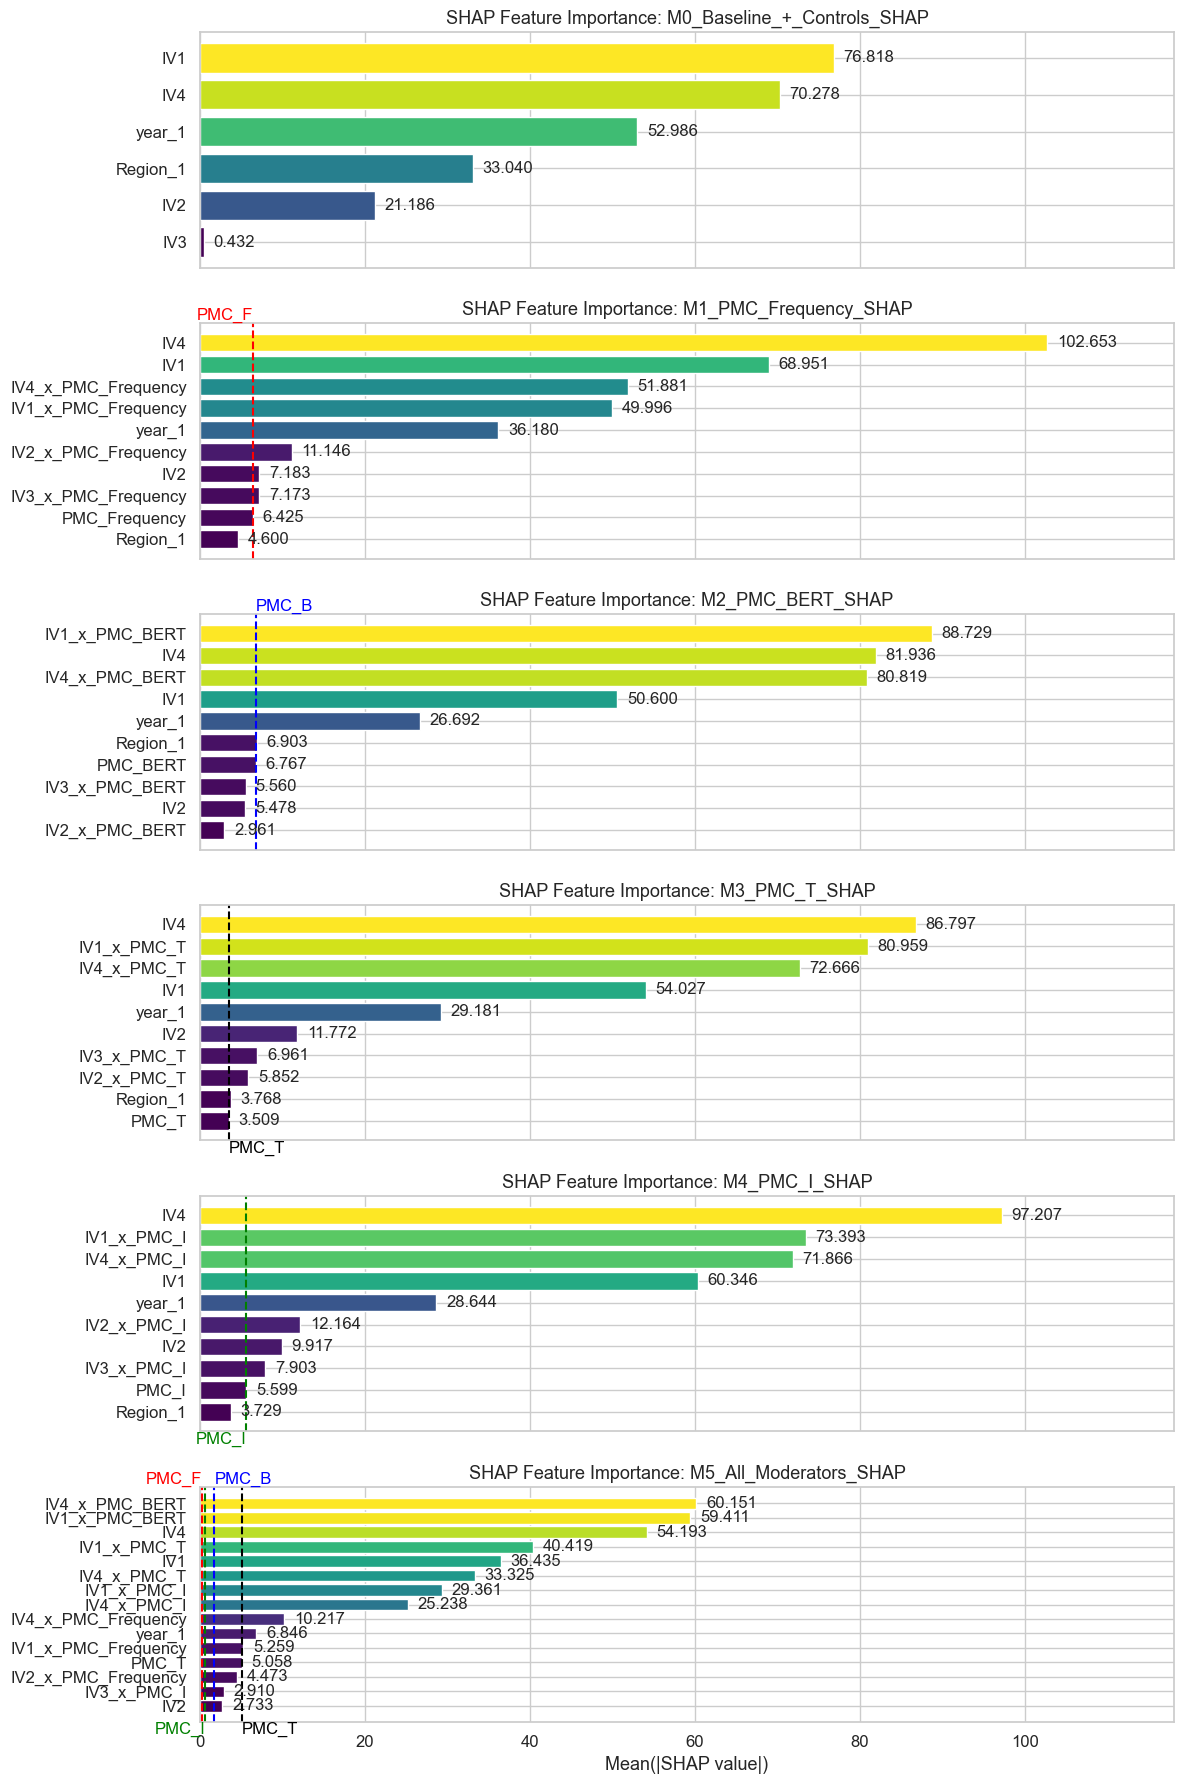

‚úÖ EÁªÑÂõæÂΩ¢ÁªòÂà∂ÂÆåÊàêÔºåËØªÂèñËá™ shap_outputs/shap_feature_comparison_all_models.csv


In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

# ==================== ‚úÖ ‰ªé CSV Êñá‰ª∂ËØªÂèñ shap Êï∞ÊçÆÊ°ÜÔºàÂä† e ÂêéÁºÄÔºâ ====================
shap_df_all_e = pd.read_csv("shap_outputs/shap_feature_comparison_all_models.csv")

# ==================== ‚úÖ ÂèØËßÜÂåñËÆæÁΩÆ ====================
top_n = 15
xmax = shap_df_all_e.set_index('Feature').max().max() * 1.15
n_models = shap_df_all_e.shape[1] - 1  # Èô§Âéª Feature Âàó

fig, axes = plt.subplots(n_models, 1, figsize=(12, 3 * n_models), sharex=True)
if n_models == 1:
    axes = [axes]

# ËÆæÂÆö PMC ÁâπÂæÅÊ†∑ÂºèÔºàÂèØÊâ©Â±ïÔºâ
pmc_features = {
    'PMC_Frequency': {'color': 'red', 'vpos': 'top', 'align': 'right', 'label': 'PMC_F'},
    'PMC_BERT':      {'color': 'blue', 'vpos': 'top', 'align': 'left',  'label': 'PMC_B'},
    'PMC_I':         {'color': 'green','vpos': 'bottom','align': 'right','label': 'PMC_I'},
    'PMC_T':         {'color': 'black','vpos': 'bottom','align': 'left','label': 'PMC_T'}
}

# ÊåâÊ®°ÂûãÁªòÂõæ
for ax, model_col in zip(axes, shap_df_all_e.columns[1:]):
    shap_series_e = shap_df_all_e[["Feature", model_col]].set_index("Feature")[model_col]
    shap_top_e = shap_series_e[shap_series_e > 0].sort_values(ascending=False).head(top_n)

    if shap_top_e.empty:
        ax.text(0.5, 0.5, 'No significant SHAP values', ha='center', va='center', fontsize=14)
        ax.set_title(f"{model_col} (No data)", fontsize=14)
        ax.set_xlim(0, xmax)
        ax.set_yticks([])
        continue

    norm = plt.Normalize(shap_top_e.min(), shap_top_e.max())
    colors = cm.viridis(norm(shap_top_e.values[::-1]))
    bars = ax.barh(shap_top_e.index[::-1], shap_top_e.values[::-1], color=colors)

    for bar in bars:
        width = bar.get_width()
        ax.text(width + xmax * 0.01, bar.get_y() + bar.get_height() / 2,
                f"{width:.3f}", va='center', ha='left', fontsize=12)

    ax.set_title(f"SHAP Feature Importance: {model_col}", fontsize=13)
    ax.set_xlim(0, xmax)
    ax.tick_params(axis='both', labelsize=12)

    for feat, style in pmc_features.items():
        if feat in shap_series_e.index and shap_series_e[feat] > 0:
            val = shap_series_e[feat]
            ax.axvline(val, color=style['color'], linestyle='--', linewidth=1.5)
            y = ax.get_ylim()[1] if style['vpos'] == 'top' else ax.get_ylim()[0]
            va = 'bottom' if style['vpos'] == 'top' else 'top'
            ax.text(val, y, style['label'], rotation=0,
                    color=style['color'], va=va, ha=style['align'], fontsize=12)

plt.xlabel("Mean(|SHAP value|)", fontsize=13)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.show()

print("‚úÖ EÁªÑÂõæÂΩ¢ÁªòÂà∂ÂÆåÊàêÔºåËØªÂèñËá™ shap_outputs/shap_feature_comparison_all_models.csv")

## FÁªÑcode  waterfall chart

In [23]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import os

# ÂàõÂª∫ËæìÂá∫ÁõÆÂΩï
output_dir = "shap_waterfall_outputs"
os.makedirs(output_dir, exist_ok=True)

# Step 1: ÊâæÂà∞ y ‰∏≠ÊúÄÊé•Ëøë‰∏≠‰ΩçÊï∞ÁöÑÊ†∑Êú¨
if not isinstance(y, pd.Series):
    y = pd.Series(y)

median_y = y.median()
sample_idx = (y - median_y).abs().idxmin()
true_value = y.loc[sample_idx]
print(f"‰∏≠‰ΩçÊï∞ y ‚âà {median_y:.3f}")
print(f"ÈÄâÂÆöÊ†∑Êú¨Á¥¢Âºï‰∏∫: {sample_idx}ÔºåÁúüÂÆûÂÄº: {true_value:.3f}")

# Step 2: ÈÅçÂéÜÊâÄÊúâÊ®°ÂûãÁªòÂà∂ waterfall Âõæ
for model_name, (model, X) in model_objects.items():
    try:
        explainer = shap.Explainer(model, X)
        shap_values = explainer(X)

        # ÊâæÂà∞ËØ•Ê†∑Êú¨ÁöÑÁâπÂæÅÂêëÈáè‰ΩçÁΩÆÔºàË°åÂè∑Ôºâ
        sample_pos = X.index.get_loc(sample_idx)
        sample_features = X.iloc[sample_pos]
        predicted_value = model.predict(X.iloc[[sample_pos]])[0]

        print(f"\n[{model_name}] È¢ÑÊµãÂÄº: {predicted_value:.3f} | ÁúüÂÆûÂÄº: {true_value:.3f}")

        # Step 3: ÁªòÂà∂ SHAP waterfall Âõæ
        plt.figure(figsize=(8, 6))
        shap.plots.waterfall(shap_values[sample_pos], max_display=10, show=False)
        plt.suptitle(
            f"{model_name}\nPredicted: {predicted_value:.3f} | Actual: {true_value:.3f}",
            x=0.02, y=1.05, ha='left', fontsize=13
        )
        plt.tight_layout()

        # Step 4: ‰øùÂ≠òÂõæÂÉè
        safe_name = model_name.replace(" ", "_").replace("(", "").replace(")", "")
        filename = os.path.join(output_dir, f"shap_waterfall_{safe_name}_sample{sample_idx}.png")
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºö{filename}")

        plt.close()
    except Exception as e:
        print(f"ÈîôËØØÂú®Ê®°Âûã {model_name} ‰∏≠Ôºö{e}")


‰∏≠‰ΩçÊï∞ y ‚âà -1.140
ÈÄâÂÆöÊ†∑Êú¨Á¥¢Âºï‰∏∫: 0ÔºåÁúüÂÆûÂÄº: -1.140

[M0 (Baseline + Controls)] È¢ÑÊµãÂÄº: 230.972 | ÁúüÂÆûÂÄº: -1.140
ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºöshap_waterfall_outputs\shap_waterfall_M0_Baseline_+_Controls_sample0.png

[M1 (PMC_Frequency)] È¢ÑÊµãÂÄº: 249.160 | ÁúüÂÆûÂÄº: -1.140
ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºöshap_waterfall_outputs\shap_waterfall_M1_PMC_Frequency_sample0.png

[M2 (PMC_BERT)] È¢ÑÊµãÂÄº: 135.047 | ÁúüÂÆûÂÄº: -1.140
ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºöshap_waterfall_outputs\shap_waterfall_M2_PMC_BERT_sample0.png

[M3 (PMC_T)] È¢ÑÊµãÂÄº: 171.678 | ÁúüÂÆûÂÄº: -1.140
ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºöshap_waterfall_outputs\shap_waterfall_M3_PMC_T_sample0.png

[M4 (PMC_I)] È¢ÑÊµãÂÄº: 172.090 | ÁúüÂÆûÂÄº: -1.140
ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºöshap_waterfall_outputs\shap_waterfall_M4_PMC_I_sample0.png

[M5 (All Moderators)] È¢ÑÊµãÂÄº: 137.335 | ÁúüÂÆûÂÄº: -1.140
ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºöshap_waterfall_outputs\shap_waterfall_M5_All_Moderators_sample0.png


## GÁªÑcode ÊâÄÊúâÂõæÊâìÂåÖ

In [24]:
import shap
import matplotlib.pyplot as plt
import os
import zipfile
import re

# ËæìÂá∫ÁõÆÂΩïÔºåÂ≠òÊîæÂõæÂÉèÊñá‰ª∂
output_dir = "shap_plots_output"
os.makedirs(output_dir, exist_ok=True)

# Êñá‰ª∂Ë∑ØÂæÑÂàóË°®ÔºåÁî®‰∫éÂêéÁª≠ÊâìÂåÖ
file_paths = []

# ÈÅçÂéÜÊ®°ÂûãÁîüÊàêÂ§öÁßç SHAP Âõæ
for model_name, (model, X_model) in model_objects.items():
    print(f"Ê≠£Âú®Â§ÑÁêÜ: {model_name}")
    explainer = shap.Explainer(model, X_model)
    shap_values = explainer(X_model)

    # ÂÆâÂÖ®Â§ÑÁêÜ model_name Áî®‰∫éÊñá‰ª∂Âêç
    safe_name = re.sub(r'[^\w\s]', '_', model_name)  # ÊõøÊç¢ÊâÄÊúâÈùûÂ≠óÊØçÊï∞Â≠óÂ≠óÁ¨¶

    # BEESWARM
    beeswarm_file = os.path.join(output_dir, f"{safe_name}_beeswarm.png")
    file_paths.append(beeswarm_file)
    plt.figure()
    shap.plots.beeswarm(shap_values, max_display=10, show=False)
    plt.title(f"{model_name} ‚Äî Beeswarm")
    plt.tight_layout()
    plt.savefig(beeswarm_file, dpi=300)
    plt.close()

    # SCATTERÔºàÈíàÂØπ PMC_BERTÔºâ
    scatter_file = os.path.join(output_dir, f"{safe_name}_scatter_PMC_BERT.png")
    file_paths.append(scatter_file)
    plt.figure()
    if "PMC_BERT" in shap_values.feature_names:
        shap.plots.scatter(shap_values[:, "PMC_BERT"], show=False)
        plt.title(f"{model_name} ‚Äî Scatter: PMC_BERT")
    else:
        plt.text(0.5, 0.5, "'PMC_BERT' not found", ha='center', va='center')
        plt.title(f"{model_name} ‚Äî Scatter: PMC_BERT")
    plt.tight_layout()
    plt.savefig(scatter_file, dpi=300)
    plt.close()

    # DEPENDENCEÔºàPMC_BERT x IV1Ôºâ
    dependence_file = os.path.join(output_dir, f"{safe_name}_dependence_PMC_BERT_x_IV1.png")
    file_paths.append(dependence_file)
    plt.figure()
    if "PMC_BERT" in X_model.columns and "IV1" in X_model.columns:
        shap.dependence_plot("PMC_BERT", shap_values.values, features=X_model, interaction_index="IV1", show=False)
        plt.title(f"{model_name} ‚Äî Dependence: PMC_BERT x IV1")
    else:
        plt.text(0.5, 0.5, "'PMC_BERT' or 'IV1' not found", ha='center', va='center')
        plt.title(f"{model_name} ‚Äî Dependence: PMC_BERT x IV1")
    plt.tight_layout()
    plt.savefig(dependence_file, dpi=300)
    plt.close()

    # HEATMAPÔºàSHAP summary_plotÔºâ
    heatmap_file = os.path.join(output_dir, f"{safe_name}_heatmap.png")
    file_paths.append(heatmap_file)
    plt.figure()
    shap.summary_plot(shap_values.values, X_model, show=False)
    plt.title(f"{model_name} ‚Äî SHAP Heatmap")
    plt.tight_layout()
    plt.savefig(heatmap_file, dpi=300)
    plt.close()

    # BARÔºàÁâπÂæÅÈáçË¶ÅÊÄßÔºâ
    bar_file = os.path.join(output_dir, f"{safe_name}_bar.png")
    file_paths.append(bar_file)
    plt.figure()
    shap.plots.bar(shap_values, max_display=10, show=False)
    plt.title(f"{model_name} ‚Äî Bar Summary")
    plt.tight_layout()
    plt.savefig(bar_file, dpi=300)
    plt.close()

    # WATERFALLÔºàÁ¨¨‰∏Ä‰∏™Ê†∑Êú¨Ôºâ
    waterfall_file = os.path.join(output_dir, f"{safe_name}_waterfall_sample0.png")
    file_paths.append(waterfall_file)
    plt.figure()
    shap.plots.waterfall(shap_values[0], show=False)
    plt.title(f"{model_name} ‚Äî Waterfall (Sample 0)")
    plt.tight_layout()
    plt.savefig(waterfall_file, dpi=300)
    plt.close()

# Step: ÊâìÂåÖÊâÄÊúâÂõæÂÉèÊñá‰ª∂‰∏∫ ZIP
zip_file_path = "shap_plots_output.zip"
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for file in file_paths:
        zipf.write(file, os.path.relpath(file, output_dir))

print(f"\n‚úÖ ÊâÄÊúâ SHAP ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Êñá‰ª∂Â§π: {output_dir}")
print(f"‚úÖ ÂõæÂÉèÂ∑≤ÊâìÂåÖ‰∏∫ ZIP Êñá‰ª∂: {zip_file_path}")


Ê≠£Âú®Â§ÑÁêÜ: M0 (Baseline + Controls)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


Ê≠£Âú®Â§ÑÁêÜ: M1 (PMC_Frequency)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


Ê≠£Âú®Â§ÑÁêÜ: M2 (PMC_BERT)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


Ê≠£Âú®Â§ÑÁêÜ: M3 (PMC_T)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


Ê≠£Âú®Â§ÑÁêÜ: M4 (PMC_I)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)


Ê≠£Âú®Â§ÑÁêÜ: M5 (All Moderators)


C:\Users\Eric\AppData\Local\Temp\ipykernel_5316\909953148.py:65: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_model, show=False)



‚úÖ ÊâÄÊúâ SHAP ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Êñá‰ª∂Â§π: shap_plots_output
‚úÖ ÂõæÂÉèÂ∑≤ÊâìÂåÖ‰∏∫ ZIP Êñá‰ª∂: shap_plots_output.zip


## <b>HÁªÑcode Robustness test

 Êñ∞Â¢ûÂäüËÉΩÔºö‰ΩøÁî® CÁªÑÊ®°ÂûãËØÑ‰º∞ÁªìÊûú‰∏≠ÁöÑ M0 ‰Ωú‰∏∫ benchmark
ËØªÂèñ CÁªÑÊ®°ÂûãËØÑ‰º∞ÁªìÊûú.csv

ÊèêÂèñ M0 ÁöÑÔºö

RMSE

MSE

R¬≤

Âú® plot_bootstrap_results ‰∏≠ËøõË°åÂ¶Ç‰∏ãÁªèÈ™å P ÂÄºËÆ°ÁÆóÔºö

RMSE/MSEÔºöÂà§Êñ≠ÊòØÂê¶Â∞è‰∫é baselineÔºàÊõ¥Â•ΩÔºâ

R¬≤/Explained VarianceÔºöÂà§Êñ≠ÊòØÂê¶Â§ß‰∫é baselineÔºàÊõ¥Â•ΩÔºâ

‰∏∫‰∫ÜËØÑ‰º∞Ê®°Âûã M5 ÁöÑÁ®≥ÂÅ•ÊÄßÔºåÊàë‰ª¨Âü∫‰∫é bootstrap ÊñπÊ≥ïÂØπÂÖ∂È¢ÑÊµãÊÄßËÉΩÔºàÂåÖÊã¨ MSE„ÄÅRMSE„ÄÅR¬≤ Âíå Explained VarianceÔºâËøõË°å‰∫ÜÈáçÂ§çÊäΩÊ†∑ÂàÜÂ∏ÉÊ®°ÊãüÔºàn = 1000Ôºâ„ÄÇÈöèÂêéÔºåÊàë‰ª¨Â∞Ü M5 ÁöÑ bootstrap ÂàÜÂ∏É‰∏é baseline Ê®°Âûã M0Ôºà‰ªÖÂåÖÂê´ÊéßÂà∂ÂèòÈáè‰∏éËá™ÂèòÈáèÔºâÊâÄÂæóÁöÑÊÄßËÉΩÊåáÊ†áËøõË°åÁªèÈ™åÊØîËæÉ„ÄÇÂÖ∑‰ΩìËÄåË®ÄÔºåÂØπ‰∫é RMSE Âíå MSEÔºåP ÂÄºË°®Á§∫ M5 ÁöÑ bootstrap ÁªìÊûú‰∏≠ÊúâÂ§öÂ∞ëÊØî‰æãÂ§ß‰∫éÊàñÁ≠â‰∫é M0 ÁöÑÂü∫ÂáÜÂÄºÔºõÂØπ‰∫é R¬≤ Âíå Explained VarianceÔºåP ÂÄºË°®Á§∫ÂÖ∂‰∏≠ÊúâÂ§öÂ∞ëÊØî‰æãÂ∞è‰∫éÊàñÁ≠â‰∫é M0 ÁöÑÂü∫ÂáÜÂÄº„ÄÇËØ•ÁªèÈ™å P ÂÄºË°°Èáè‰∫Ü M5 Âú®‰∏çÂêåÊäΩÊ†∑‰∏ãÊòØÂê¶Á®≥ÂÆö‰ºò‰∫é baselineÔºå‰ªéËÄåÈó¥Êé•ÂèçÊò†Ê®°ÂûãÂú®ÂΩìÂâçÊï∞ÊçÆ‰∏≠ÁöÑÁõ∏ÂØπ‰ºòÂäøÂèäÁ®≥ÂÅ•ÊÄß„ÄÇÔºåP ÂÄºÂú®Âõæ‰∏≠‰ª•‰∏âÁßçÊòæËëóÊÄßÊ†áËÆ∞Ë°®Á§∫Ôºöp < 0.05Ôºà*Ôºâ„ÄÅ< 0.01Ôºà**Ôºâ„ÄÅ< 0.005Ôºà *** Ôºâ„ÄÇ

ËôΩÁÑ∂ M5 Ê®°ÂûãÂú®ËØØÂ∑ÆÊåáÊ†áÔºàMSE, RMSEÔºâ‰∏éÊï¥‰ΩìÊãüÂêàÂ∫¶ÔºàR¬≤Ôºâ‰∏äÊòæËëó‰ºò‰∫é baselineÔºå‰ΩÜÂú® explained variance ÊåáÊ†á‰∏äÊú™Ë°®Áé∞Âá∫ÁªüËÆ°ÊòæËëó„ÄÇËøôÂèØËÉΩÊ∫ê‰∫éÊ®°ÂûãËæìÂá∫ÂÄºÁöÑÊñπÂ∑ÆÊú™ËÉΩÂÖÖÂàÜË¶ÜÁõñÁõÆÊ†áÂèòÈáèÁöÑÊï¥‰ΩìÊ≥¢Âä®ÊÄßÔºåÊèêÁ§∫Â∞ΩÁÆ°Ê®°ÂûãÈ¢ÑÊµãËØØÂ∑ÆËæÉÂ∞èÔºå‰ΩÜÂÖ∂Âú®Ëß£ÈáäÂõ†ÂèòÈáèÂä®ÊÄÅÂèòÂåñÊñπÈù¢ÁöÑËÉΩÂäõÂ∞öÊúâÈôê„ÄÇ

‚úÖ Model metadata loaded: search_seed = 42 , eval_seed = 42
Bootstrap results saved to Robustness_test\bootstrap_results.csv


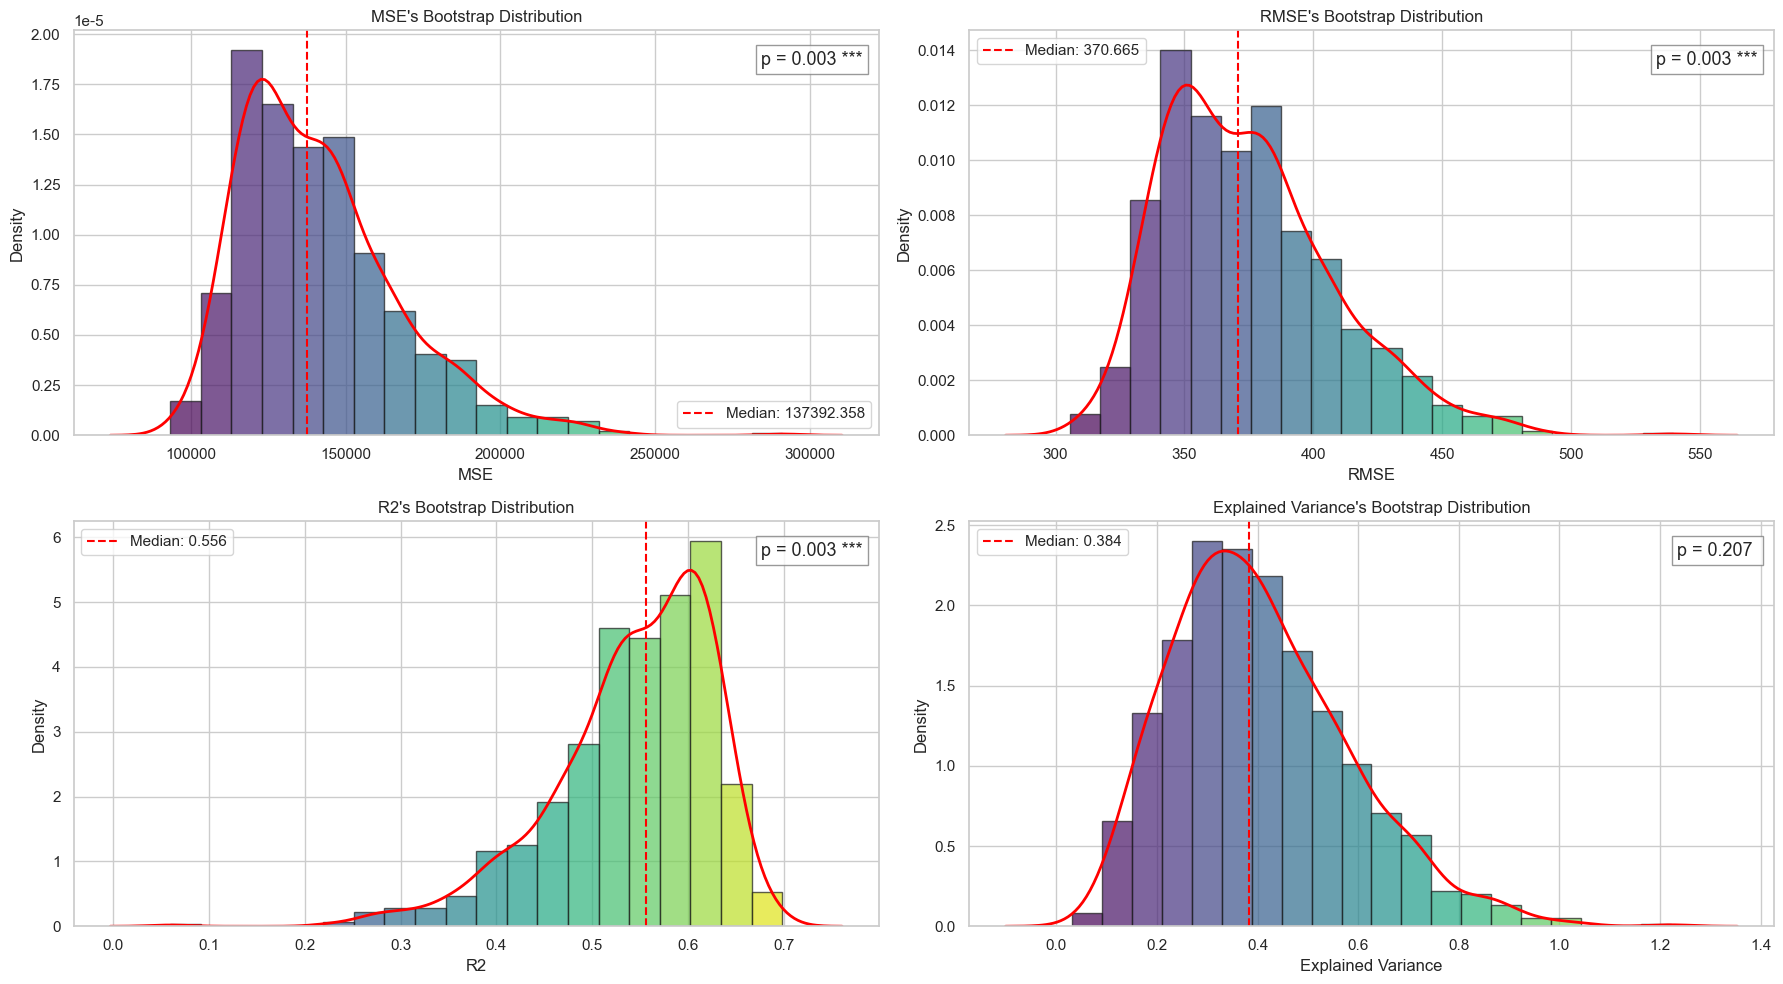

K-Fold results saved to kfold_results.csv


In [25]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed
import os
from sklearn.model_selection import KFold
import scipy.stats as stats

# ========== ‚úÖ ËÆ°ÁÆó DataFrame ÂìàÂ∏åÔºàÂõ∫ÂÆöÈ°∫Â∫è & Á±ªÂûãÔºâ ==========
def hash_df(df):
    df_sorted = df.copy()
    df_sorted = df_sorted.reindex(sorted(df_sorted.columns), axis=1)
    df_sorted = df_sorted.astype(np.float64)
    return pd.util.hash_pandas_object(df_sorted, index=True).values.sum()

# ========== ‚úÖ ËØªÂèñÊúÄ‰Ω≥Ê®°ÂûãÂèÇÊï∞ÔºàÂè™Ê†°È™åÊ®°ÂûãÊù•Ê∫êÔºåË∑≥Ëøá X/y ÂìàÂ∏åÔºâ ==========
def load_best_model_snapshot(file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)

    params = snapshot["best_params"]
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])

    meta = snapshot["meta"]
    print("‚úÖ Model metadata loaded: search_seed =", meta.get("search_seed"), ", eval_seed =", meta.get("eval_seed"))
    return params

# ========== ‚úÖ KFold ‰∫§ÂèâÈ™åËØÅ ==========
def k_fold_robustness_test_parallel(X, y, model, n_splits=3, n_jobs=-1, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = []

    for fold_num, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        mse = mean_squared_error(y_valid, y_pred)
        r2 = r2_score(y_valid, y_pred)

        results.append({"Fold": f"Fold {fold_num}", "RMSE": rmse, "MSE": mse, "R¬≤": r2})

    return pd.DataFrame(results)

# ========== ‚úÖ Bootstrap ÈáçÊäΩÊ†∑ ==========
def bootstrap_resampling_parallel(X, y, model, n_iterations=1000, n_jobs=-1):
    # ËΩ¨Êç¢ y ‰∏∫ SeriesÔºàÈò≤Ê≠¢ËøõÂÖ•Â≠êËøõÁ®ãÂá∫ÈîôÔºâ
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]
    y = np.asarray(y).ravel()  # Á°Æ‰øù‰∏∫ 1D

    results = Parallel(n_jobs=n_jobs)(
        delayed(perform_bootstrap_iteration)(X.values, y, model) for _ in range(n_iterations)
    )
    return {
        'MSE': [r[0] for r in results],
        'RMSE': [r[1] for r in results],
        'R2': [r[2] for r in results],
        'Explained Variance': [r[3] for r in results]
    }

def perform_bootstrap_iteration(X, y, model):
    X_df = pd.DataFrame(X)
    X_resampled, y_resampled = resample(X_df, y, random_state=None)
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_df)

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    explained_variance = np.var(y_pred) / np.var(y)

    return mse, rmse, r2, explained_variance

# ========== ‚úÖ Â¢ûÂº∫ÂõæÂÉèÔºöÊ∑ªÂä† P ÂÄºÔºà‰∏é CÁªÑ M0 Ê®°ÂûãÂØπÊØîÔºâ ==========
def plot_bootstrap_results(bootstrap_df, output_dir, baseline_metrics):
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()
    viridis_cmap = plt.cm.viridis

    for i, metric in enumerate(["MSE", "RMSE", "R2", "Explained Variance"]):
        data = bootstrap_df[metric]
        n, bins, patches = axes[i].hist(data, bins=20, edgecolor='k', alpha=0.7, density=True)

        for j, patch in enumerate(patches):
            plt.setp(patch, 'facecolor', viridis_cmap(j / len(patches)))

        sns.kdeplot(data, ax=axes[i], color='red', lw=2)
        median_val = np.median(data)
        axes[i].axvline(median_val, color='red', linestyle='--', label=f'Median: {median_val:.3f}')

        baseline_val = baseline_metrics.get(metric, None)
        if baseline_val is not None:
            if metric in ["MSE", "RMSE"]:
                p_val = np.mean(np.array(data) >= baseline_val)
            else:  # R2, Explained Variance
                p_val = np.mean(np.array(data) <= baseline_val)
        else:
            p_val = 1.0

        if p_val < 0.005:
            sig = '***'
        elif p_val < 0.01:
            sig = '**'
        elif p_val < 0.05:
            sig = '*'
        else:
            sig = ''

        axes[i].text(0.98, 0.95, f'p = {p_val:.3f} {sig}',
                     transform=axes[i].transAxes, fontsize=13,
                     ha='right', va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

        axes[i].set_title(f"{metric}'s Bootstrap Distribution")
        axes[i].set_xlabel(metric)
        axes[i].set_ylabel("Density")
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plot_file = os.path.join(output_dir, "Bootstrap_distribution_rf.png")
    plt.savefig(plot_file)
    plt.show()

# ========== ‚úÖ ‰øùÂ≠ò CSV ==========
def save_bootstrap_results(bootstrap_results, output_file):
    bootstrap_df = pd.DataFrame(bootstrap_results)
    bootstrap_df.to_csv(output_file, index=False)
    print(f"Bootstrap results saved to {output_file}")

# ========== ‚úÖ ‰∏ªÂáΩÊï∞ ==========
def main(X, y, best_params_file="best_model_m5.json", output_dir="Robustness_test", c_group_csv="CÁªÑÊ®°ÂûãËØÑ‰º∞ÁªìÊûú.csv"):
    os.makedirs(output_dir, exist_ok=True)

    best_params = load_best_model_snapshot(file_path=best_params_file)
    model = RandomForestRegressor(**best_params)

    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]  # ‚úÖ Á°Æ‰øù y ÊòØ Series

    # ËØªÂèñ CÁªÑ baselineÔºàM0ÔºâÁªìÊûú‰Ωú‰∏∫Âü∫ÂáÜ
    df_c = pd.read_csv(c_group_csv)
    df_m0 = df_c[df_c['Model'] == 'M0 (Baseline + Controls)'].iloc[0]
    baseline_metrics = {
        'MSE': df_m0['MSE'],
        'RMSE': df_m0['RMSE'],
        'R2': df_m0['R¬≤'],
        'Explained Variance': df_m0['R¬≤']  # Ëøë‰ººÂ§ÑÁêÜ
    }

    bootstrap_results = bootstrap_resampling_parallel(X, y, model, n_iterations=1000, n_jobs=-1)
    bootstrap_df = pd.DataFrame(bootstrap_results)

    output_file = os.path.join(output_dir, "bootstrap_results.csv")
    save_bootstrap_results(bootstrap_results, output_file)
    plot_bootstrap_results(bootstrap_df, output_dir, baseline_metrics)

    kfold_results = k_fold_robustness_test_parallel(X, y, model, n_splits=5, n_jobs=-1, random_state=42)
    kfold_results.to_csv(os.path.join(output_dir, 'kfold_results.csv'), index=False)
    print("K-Fold results saved to kfold_results.csv")

# Run
y= df_raw["Dep"]
main(X, y)

## <b>IÁªÑcode sensitivity analysis

### sensitivity analysis (I2)

In [26]:
import json
import pandas as pd
import numpy as np

# === Âä†ËΩΩÊúÄ‰Ω≥Ê®°ÂûãÂèÇÊï∞ ===
def load_best_model_snapshot(file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)

    params = snapshot["best_params"]
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])

    eval_seed = snapshot["meta"].get("eval_seed", 42)
    return params, eval_seed

# === ÈÄêÊ≠•ÁßªÈô§ÊéßÂà∂ÂèòÈáèËøõË°åÊïèÊÑüÊÄßÂàÜÊûê ===
def evaluate_sensitivity_analysis(df_combined, y, baseline_features, control_features, moderators, rf_params):
    results = []

    # ÂàùÂßãÊ®°ÂûãÔºàÂåÖÊã¨ÊâÄÊúâÊéßÂà∂ÂèòÈáèÔºâ
    df_m5, _ = build_model_features_all_v2(df_combined, baseline_features, moderators, control_features)
    rmse_m5 = evaluate_model(rf_params, df_m5, y)
    mse_m5 = rmse_m5 ** 2
    r2_m5 = 1 - mse_m5 / np.var(y)
    results.append({"Model": "M5 (All Moderators)", "RMSE": rmse_m5, "MSE": mse_m5, "R¬≤": r2_m5})

    # ÈÄêÊ≠•ÁßªÈô§ÊØè‰∏Ä‰∏™ÊéßÂà∂ÂèòÈáè
    for i in range(len(control_features)):
        control_features_subset = control_features[:i] + control_features[i+1:]
        df_m5_sub, _ = build_model_features_all_v2(df_combined, baseline_features, moderators, control_features_subset)
        rmse_sub = evaluate_model(rf_params, df_m5_sub, y)
        mse_sub = rmse_sub ** 2
        r2_sub = 1 - mse_sub / np.var(y)
        model_name = f"M5 (Control variables removed: {', '.join(control_features[i:i+1])})"
        results.append({"Model": model_name, "RMSE": rmse_sub, "MSE": mse_sub, "R¬≤": r2_sub})

    return pd.DataFrame(results)

# === ËÆæÁΩÆÂèÇÊï∞Âπ∂ÂºÄÂßãÊïèÊÑüÊÄßÂàÜÊûê ===
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

df_raw = df_combined.copy()
y = df_raw["Dep"]

# Ëé∑ÂèñÊúÄ‰Ω≥Ê®°ÂûãÂèÇÊï∞ÂíåËØÑ‰º∞ÁßçÂ≠ê
best_params, eval_seed = load_best_model_snapshot(file_path="best_model_m5.json")

# Ëé∑Âèñ M5 Ê®°ÂûãÁöÑÊïèÊÑüÊÄßÂàÜÊûêÁªìÊûú
df_sensitivity_results = evaluate_sensitivity_analysis(
    df_combined=df_raw,
    y=y,
    baseline_features=baseline_features,
    control_features=control_features,
    moderators=moderators,
    rf_params=best_params
)

# ËæìÂá∫ÁªìÊûú
print("\n========= ‚úÖ M5Ê®°ÂûãÊïèÊÑüÊÄßÂàÜÊûêÁªìÊûúÔºàÈÄêÊ≠•ÁßªÈô§ÊéßÂà∂ÂèòÈáèÔºâ =========")
print(df_sensitivity_results.to_string(index=False))

# ÂèØÈÄâ‰øùÂ≠ò‰∏∫ CSV Êñá‰ª∂  
df_sensitivity_results.to_csv("M5Ê®°ÂûãÊïèÊÑüÊÄßÂàÜÊûêÁªìÊûú.csv", index=False, encoding="utf-8-sig")
print("üìÅ M5Ê®°ÂûãÊïèÊÑüÊÄßÂàÜÊûêÁªìÊûúÂ∑≤‰øùÂ≠ò‰∏∫ M5Ê®°ÂûãÊïèÊÑüÊÄßÂàÜÊûêÁªìÊûú.csv")



========= ‚úÖ M5Ê®°ÂûãÊïèÊÑüÊÄßÂàÜÊûêÁªìÊûúÔºàÈÄêÊ≠•ÁßªÈô§ÊéßÂà∂ÂèòÈáèÔºâ =========
                                   Model       RMSE           MSE       R¬≤
                     M5 (All Moderators) 441.351833 194791.440741 0.370446
  M5 (Control variables removed: year_1) 452.698918 204936.310122 0.337659
M5 (Control variables removed: Region_1) 451.313853 203684.193945 0.341706
üìÅ M5Ê®°ÂûãÊïèÊÑüÊÄßÂàÜÊûêÁªìÊûúÂ∑≤‰øùÂ≠ò‰∏∫ M5Ê®°ÂûãÊïèÊÑüÊÄßÂàÜÊûêÁªìÊûú.csv


### I3ÁªÑ snesitivity analysis M0-5ÈáçÊñ∞ÊâæË∂ÖÂèÇÊï∞

In [33]:
import optuna
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# ==================== ‚úÖ ËØÑ‰º∞ÂáΩÊï∞ ====================
def evaluate_model(params, X, y, n_splits=3, random_state=1203):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []
    
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)
    
    return np.mean(rmse_list)

# ==================== ‚úÖ Optuna Ë∞ÉÂèÇÂáΩÊï∞ ====================
def objective(trial, X, y, model_type="M0"):
    n_samples = len(X)
    seed_val = trial.suggest_categorical('seed', [1203, 42, 2023])

    if model_type == "M0":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), 
                                                   max(15, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.02 * n_samples)), 
                                                  max(10, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M1":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), max(15, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                   max(3, int(0.02 * n_samples)), max(10, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M2":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), 
                                                   max(20, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.02 * n_samples)), 
                                                  max(15, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M3":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), max(20, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.02 * n_samples)), max(15, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M4":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), max(25, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.02 * n_samples)), max(20, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    elif model_type == "M5":
        param = {
            'n_estimators': trial.suggest_int('n_estimators', 30, 200),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'min_samples_split': trial.suggest_int('min_samples_split', 
                                                   max(3, int(0.03 * n_samples)), max(25, int(0.15 * n_samples))),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 
                                                  max(3, int(0.03 * n_samples)), max(20, int(0.1 * n_samples))),
            'max_features': trial.suggest_float('max_features', 0.25, 0.75),
            'bootstrap': False,
            'ccp_alpha': trial.suggest_float('ccp_alpha', 1e-3, 0.05),
            'n_jobs': 1,
            'warm_start': True
        }
    
    return evaluate_model(param, X, y, random_state=seed_val)

# ==================== ‚úÖ ËøõË°åË∂ÖÂèÇÊï∞‰ºòÂåñÂπ∂ËØÑ‰º∞ M0 Âà∞ M5 ====================
def run_sensitivity_analysis(df_combined, baseline_features, control_features, moderators):
    # Get the data for modeling
    df_m5, m5_features = build_model_features_all_v2(df_combined, baseline_features, moderators, control_features)
    X = df_m5
    y = df_combined["Dep"]

    # Create a dictionary to store results for each model (M0 to M5)
    results_i3 = []

    # Iterate through models M0 to M5
    for model_type in ["M0", "M1", "M2", "M3", "M4", "M5"]:
        # Optimize hyperparameters for each model
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X, y, model_type), n_trials=100)
        
        best_rmse = study.best_value
        best_mse = best_rmse ** 2
        best_r2 = 1 - best_mse / np.var(y)
        
        best_params = study.best_trial.params
        best_seed = best_params.pop("seed")
        best_params['random_state'] = best_seed
        
        # Store results
        results_i3.append({
            "Model": model_type,
            "RMSE": best_rmse,
            "MSE": best_mse,
            "R¬≤": best_r2,
            "Best_Params": best_params
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results_i3)
    
    # Save to CSV
    results_df.to_csv("i3_sensitivity_results.csv", index=False)
    print(f"Results saved as i3_sensitivity_results.csv")
    
    return results_df

# ==================== ‚úÖ ËøêË°åÊïèÊÑüÊÄßÂàÜÊûê ====================
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
control_features = ["year_1", "Region_1"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

df_raw = df_combined.copy()

# Run sensitivity analysis for M0-M5
df_sensitivity_results_i3 = run_sensitivity_analysis(df_combined=df_raw, 
                                                    baseline_features=baseline_features,
                                                    control_features=control_features,
                                                    moderators=moderators)

# Display the results
print(df_sensitivity_results_i3)

[I 2025-10-05 08:15:31,158] A new study created in memory with name: no-name-acc6c7d6-ed6e-4530-9257-727694e3cdb5
[I 2025-10-05 08:15:31,363] Trial 0 finished with value: 419.9553733175385 and parameters: {'seed': 2023, 'n_estimators': 151, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 0.35007502820599357, 'ccp_alpha': 0.03594208555278542}. Best is trial 0 with value: 419.9553733175385.
[I 2025-10-05 08:15:31,468] Trial 1 finished with value: 492.4805260241694 and parameters: {'seed': 2023, 'n_estimators': 73, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.5850898787796972, 'ccp_alpha': 0.011996652285614147}. Best is trial 0 with value: 419.9553733175385.
[I 2025-10-05 08:15:31,714] Trial 2 finished with value: 421.97339167287237 and parameters: {'seed': 42, 'n_estimators': 184, 'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 9, 'max_features': 0.5533268077039697, 'ccp_alpha': 0.003431161495295606}. Best is

Results saved as i3_sensitivity_results.csv
  Model        RMSE            MSE        R¬≤  \
0    M0  369.782176  136738.857884  0.558069   
1    M1  368.478257  135776.225537  0.561180   
2    M2  366.814490  134552.870310  0.565134   
3    M3  371.410264  137945.584062  0.554169   
4    M4  387.287171  149991.353050  0.515237   
5    M5  386.101755  149074.565203  0.518200   

                                         Best_Params  
0  {'n_estimators': 152, 'max_depth': 3, 'min_sam...  
1  {'n_estimators': 88, 'max_depth': 6, 'min_samp...  
2  {'n_estimators': 64, 'max_depth': 6, 'min_samp...  
3  {'n_estimators': 134, 'max_depth': 6, 'min_sam...  
4  {'n_estimators': 103, 'max_depth': 3, 'min_sam...  
5  {'n_estimators': 95, 'max_depth': 5, 'min_samp...  


#### JÁªÑ ÂüéÂ∏ÇÂ±ÇÁ∫ßÊØîËæÉ
Êää ‚ÄúPMC ÊåáÊ†á + Â∏ÇÂú∫Êù°‰ª∂‚Äù ÁöÑÂèëÁé∞Ëøõ‰∏ÄÊ≠•ÊîæÂà∞ÂüéÂ∏ÇÂ±ÇÁ∫ßÁöÑÊØîËæÉËØ≠Â¢ÉÈáå

In [40]:
# ==================== üìÇ JÁªÑ‰ª£Á†ÅÔºöPMC √ó ÂüéÂ∏ÇÂ±ÇÁ∫ß‰∫§‰∫í + ÂõõÈò∂‰∫§‰∫íÂèØËßÜÂåñ ====================
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import os

# ========== Step 0. ËØªÂèñ best_params ==========
def load_best_model_snapshot(file_path="best_model_m5.json"):
    with open(file_path, "r") as f:
        snapshot = json.load(f)
    params = snapshot["best_params"]

    # ËΩ¨Êç¢ÂèÇÊï∞Á±ªÂûã
    for k in ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf"]:
        params[k] = int(params[k])
    for k in ["max_features", "ccp_alpha"]:
        params[k] = float(params[k])
    params["random_state"] = int(params["random_state"])
    print("‚úÖ best_params Â∑≤‰ªé JSON Êñá‰ª∂Âä†ËΩΩÊàêÂäü")
    return params

# ========== Step 1. ÊûÑÈÄ†ÂüéÂ∏ÇÂ±ÇÁ∫ßÂèòÈáèÔºàDummyÔºâ ==========
def add_region_dummies(df, region_col="Region_1"):
    """
    Â∞Ü Region_1 ËΩ¨Êç¢‰∏∫‰∏ÄÁ∫ø/‰∫åÁ∫ø/‰∏âÁ∫øÂüéÂ∏ÇÁöÑÂìëÂèòÈáè
    """
    df_region = pd.get_dummies(df[region_col], prefix="Region", drop_first=True)
    return pd.concat([df, df_region], axis=1), list(df_region.columns)

# ========== Step 2. ÊûÑÈÄ†ÁâπÂæÅ ==========
def build_features_with_region_interactions(df, baseline, moderators, region_dummies):
    df_temp = df.copy()
    features = list(baseline) + moderators + region_dummies

    # PMC √ó Region ‰∫§‰∫íÈ°π
    for mod in moderators:
        for reg in region_dummies:
            inter_col = f"{mod}_x_{reg}"
            df_temp[inter_col] = df_temp[mod] * df_temp[reg]
            features.append(inter_col)

    # IV √ó PMC ‰∫§‰∫íÈ°π
    for mod in moderators:
        for iv in baseline:
            inter_col = f"{iv}_x_{mod}"
            df_temp[inter_col] = df_temp[iv] * df_temp[mod]
            features.append(inter_col)

    # Êñ∞Â¢ûÔºöPMC ÂõõÈò∂Êï¥‰Ωì‰∫§‰∫í
    if all(m in df_temp.columns for m in moderators):
        inter_col = "PMC_AllInteraction"
        df_temp[inter_col] = (
            df_temp["PMC_Frequency"] *
            df_temp["PMC_BERT"] *
            df_temp["PMC_T"] *
            df_temp["PMC_I"]
        )
        features.append(inter_col)

        # IV1 √ó PMC_All
        iv1_inter = "IV1_x_PMC_ALL"
        df_temp[iv1_inter] = df_temp["IV1"] * df_temp[inter_col]
        features.append(iv1_inter)

        # IV4 √ó PMC_All
        iv4_inter = "IV4_x_PMC_ALL"
        df_temp[iv4_inter] = df_temp["IV4"] * df_temp[inter_col]
        features.append(iv4_inter)

    return df_temp[features], features

# ========== Step 3. ËØÑ‰º∞ÂáΩÊï∞ ==========
def evaluate_model(params, X, y, n_splits=3, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_list = []
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = RandomForestRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_list.append(rmse)
    return np.mean(rmse_list)

# ========== Step 4. SHAP ÂàÜÂ±ÇÂèØËßÜÂåñ + CSV ==========
def shap_by_region(model, X, df, region_col="Region_1", out_dir="./shap_plots_output/J_code_plots"):
    os.makedirs(out_dir, exist_ok=True)

    # ËÆ°ÁÆó SHAP
    explainer = shap.Explainer(model, X.astype(float))
    shap_values = explainer(X.astype(float))

    # ‰øùÂ≠ò SHAP ÂÄºÂà∞ DataFrame
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df[region_col] = df[region_col].values  # ÈôÑÂä†ÂüéÂ∏ÇÂ±ÇÁ∫ß
    shap_df["Dep"] = df["Dep"].values           # ÈôÑÂä†Âõ†ÂèòÈáè

    # === ‰øùÂ≠ò‰∏∫ CSV Êñá‰ª∂ ===
    csv_path = f"{out_dir}/Jgroup_shap_values.csv"
    shap_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"‚úÖ SHAP ÂÄºÂ∑≤‰øùÂ≠ò‰∏∫ CSV: {os.path.abspath(csv_path)}")

    # === ÁªòÂà∂ÂÖ≥ÈîÆ‰∫§‰∫íÈ°π 3√ó3 ÁÆ±Á∫øÂõæ ===
    plot_key_interactions(shap_df, region_col=region_col, out_dir=out_dir)

    return shap_df

# ========== Step 5. ÁªòÂà∂ÂÖ≥ÈîÆ‰∫§‰∫íÈ°π 3√ó3 ÁÆ±Á∫øÂõæ ==========

# ========== Step 5. ÁªòÂà∂ÂÖ≥ÈîÆ‰∫§‰∫íÈ°π 3√ó3 ÁÆ±Á∫øÂõæ ==========
def plot_key_interactions(shap_df, region_col="Region_1", out_dir="./shap_plots_output/J_code_plots"):
    key_features = [
        "IV1_x_PMC_BERT", "IV1_x_PMC_T", "IV4_x_PMC_BERT",
        "IV4_x_PMC_T", "IV4_x_PMC_I", "IV2_x_PMC_Frequency",
        "IV2_x_PMC_I", "IV1_x_PMC_ALL", "IV4_x_PMC_ALL"
    ]

    # ÁæéËßÇÂèòÈáèÂêçÊò†Â∞Ñ
    pretty_names = {
        "IV1_x_PMC_BERT": "HousePrice(IV_1) √ó PMC_B",
        "IV1_x_PMC_T": "HousePrice(IV_1) √ó PMC_T",
        "IV4_x_PMC_BERT": "Capital(IV_4) √ó PMC_B",
        "IV4_x_PMC_T": "Capital(IV_4) √ó PMC_T",
        "IV4_x_PMC_I": "Capital(IV_4) √ó PMC_I",
        "IV2_x_PMC_Frequency": "Absorption(IV_2) √ó PMC_F",
        "IV2_x_PMC_I": "Absorption(IV_2) √ó PMC_I",
        "IV1_x_PMC_ALL": "HousePrice(IV_1) √ó [PMC_T, PMC_I, PMC_F, PMC_B]",
        "IV4_x_PMC_ALL": "Capital(IV_4) √ó [PMC_T, PMC_I, PMC_F, PMC_B]"
    }

    n_cols = 3
    n_rows = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    for i, feat in enumerate(key_features):
        ax = axes[i]

        # ‰ΩøÁî® viridis Ëâ≤Âç°ÔºåÁº©Â∞èÁÆ±‰ΩìÂÆΩÂ∫¶
        sns.boxplot(
            x=region_col, y=feat, data=shap_df,
            palette="viridis", width=0.3, ax=ax
        )
        ax.axhline(0, color="black", linestyle="--")
        ax.set_title(pretty_names.get(feat, feat), fontsize=11)
        ax.set_xlabel("City Tier")
        ax.set_ylabel("SHAP value")

        # ËÆ°ÁÆóÂπ∂Ê†áÊ≥®ÂùáÂÄº
        means = shap_df.groupby(region_col)[feat].mean()
        for j, (tier, mean_val) in enumerate(means.items()):
            ax.text(
                j, mean_val, f"Mean = {mean_val:.3f}",
                color="brown", fontsize=9, ha="center", va="bottom", fontweight="bold"
            )

    plt.tight_layout()
    plt.savefig(f"{out_dir}/Jgroup_KeyInteractions.png", dpi=300)
    plt.close()
    print(f"‚úÖ ÂÖ≥ÈîÆ‰∫§‰∫í SHAP ÁÆ±ÂûãÂõæ (3√ó3, viridis, Âê´ÂùáÂÄºÊ†áÊ≥®, ÁæéËßÇÁº©ÂÜô) Â∑≤‰øùÂ≠òËá≥ {os.path.abspath(out_dir)}")



# ========== Step 6. ‰∏ªÊµÅÁ®ã ==========
def main_Jgroup(df_combined, baseline, moderators, json_file="best_model_m5.json"):
    # 1. ËØªÂèñ best_params
    best_params = load_best_model_snapshot(json_file)

    # 2. Â¢ûÂä† Region dummy
    df_with_region, region_dummies = add_region_dummies(df_combined, region_col="Region_1")

    # 3. ÊûÑÈÄ†ÁâπÂæÅ
    X, features = build_features_with_region_interactions(
        df_with_region, baseline, moderators, region_dummies
    )
    X = X.apply(pd.to_numeric, errors="coerce")
    y = df_with_region["Dep"]

    # 4. ËÆ≠ÁªÉÊ®°Âûã
    model = RandomForestRegressor(**best_params)
    model.fit(X, y)

    # 5. Ê®°ÂûãÊÄßËÉΩ
    rmse = evaluate_model(best_params, X, y)
    print(f"üìä JÁªÑÊ®°Âûã (Âê´ PMC√óRegion + PMC ÂõõÈò∂‰∫§‰∫í) RMSE = {rmse:.3f}")

    # 6. SHAP ÂàÜÂ±ÇÂèØËßÜÂåñ + ÂÖ≥ÈîÆ‰∫§‰∫íÂá∫Âõæ
    shap_df = shap_by_region(model, X, df_with_region, region_col="Region_1")

    return model, X, y, shap_df

# ==================== ÊâßË°åÂÖ•Âè£ ====================
baseline_features = ["IV1", "IV2", "IV3", "IV4"]
moderators = ["PMC_Frequency", "PMC_BERT", "PMC_T", "PMC_I"]

# ÂÅáËÆæ df_combined Â∑≤ÁªèÂ≠òÂú®
model_J, X_J, y_J, shap_J = main_Jgroup(df_combined, baseline_features, moderators)


‚úÖ best_params Â∑≤‰ªé JSON Êñá‰ª∂Âä†ËΩΩÊàêÂäü
üìä JÁªÑÊ®°Âûã (Âê´ PMC√óRegion + PMC ÂõõÈò∂‰∫§‰∫í) RMSE = 392.446
‚úÖ SHAP ÂÄºÂ∑≤‰øùÂ≠ò‰∏∫ CSV: C:\bgy\C-documents\Á¢ßÊ°ÇÂõ≠\ÈõÜÂõ¢ËøêËê•ÁÆ°ÁêÜÂ∑•‰Ωú\‰∏ìÈ°πÂ∑•‰Ωú\2023Âπ¥‰øù‰∫§Ê•º\23-12-15\ÂàòÁ£ä-ÁõëÊéßËµÑÈáëÊîøÁ≠ñÂàÜÊûê\code\shap_plots_output\J_code_plots\Jgroup_shap_values.csv


C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2514056664.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2514056664.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2514056664.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Eric\AppData\Local\Temp\ipykernel_5476\2514056664.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

‚úÖ ÂÖ≥ÈîÆ‰∫§‰∫í SHAP ÁÆ±ÂûãÂõæ (3√ó3, viridis, Âê´ÂùáÂÄºÊ†áÊ≥®, ÁæéËßÇÁº©ÂÜô) Â∑≤‰øùÂ≠òËá≥ C:\bgy\C-documents\Á¢ßÊ°ÇÂõ≠\ÈõÜÂõ¢ËøêËê•ÁÆ°ÁêÜÂ∑•‰Ωú\‰∏ìÈ°πÂ∑•‰Ωú\2023Âπ¥‰øù‰∫§Ê•º\23-12-15\ÂàòÁ£ä-ÁõëÊéßËµÑÈáëÊîøÁ≠ñÂàÜÊûê\code\shap_plots_output\J_code_plots


## KÁªÑ‰ª£Á†Å
1\. ÊûÑÈÄ†‚ÄúÂõõÊù†ÊùÜ‰∏ÄËá¥ÊÄßÊåáÊ†á‚ÄùÁöÑËÆ°ÁÆóÂáΩÊï∞Ôºà0‚Äì10 Ê†áÂáÜÂåñÔºåË¶ÅÊ±Ç‰∏âÊù†ÊùÜÈÉΩÊúâÈùûÈõ∂Ë¶ÜÁõñÔºâÔºõ

2\. ÁîüÊàêÊ∂àËûçÂÆûÈ™åÔºàA/B ‰∏§Â±ÇÔºâÁªìÊûúÈ™®Êû∂ CSVÔºåÊï∞ÂÄºÁïô placeholderÔºà‚Äì0.0## / +0.### Á≠âÔºâ‰æø‰∫éÂêéÁª≠Â°´Êï∞Ôºõ

3\. ‰ªé J ÁªÑÂØºÂá∫ÁöÑ Jgroup_shap_values.csv ÈáåÂèñÂÖ≥ÈîÆ‰∫§‰∫íÔºåÁîª 3√ó3 viridis ÁÆ±Á∫øÂõæÔºàÁÆ±‰ΩìÁ™Ñ„ÄÅÊ†áÊ≥®ÂùáÂÄº Mean = ##.###ÔºâÔºõ

4\. Ëá™Âä®ÂêêÂá∫ Appendix #8 ÁöÑ Markdown ËçâÁ®øÔºàA8.1‚ÄìA8.4 Â∞èËäÇÔºâÔºåÊääË°®Ê†º‰∏éÂõæÁöÑÊñá‰ª∂Ë∑ØÂæÑÈÉΩÂÜôÂ•Ω„ÄÇ

5\. ËæìÂá∫ÁõÆÂΩïÔºö./ablation_design/ÔºàCSV + MarkdownÔºâ„ÄÅ./ablation_design/fig/ÔºàÂõæÔºâ

In [46]:
# ==================== üìÇ KÁªÑÔºàÊ≠£ÂºèÁâàÔºâÔºöÂê´ CV1/CV2 ÁöÑÂü∫Á∫ø + Âõ∫ÂÆöÊäòÂàÜ + ŒîÊÄßËÉΩ + ŒîSHAP + ÁÉ≠ÂäõÂõæ ====================
import os
import json
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# -------------------- ÂÖ®Â±ÄÈÖçÁΩÆ --------------------
SEED = 42
N_SPLITS = 5
JSON_PATH = "best_model_m5.json"

OUT_DIR = "./ablation_design"
SHAP_DIR = os.path.join(OUT_DIR, "shap_deltas")
FIG_DIR  = os.path.join(OUT_DIR, "fig")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(SHAP_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# -------------------- Â∑•ÂÖ∑ÂáΩÊï∞ --------------------
def load_best_params(json_path=JSON_PATH):
    with open(json_path, "r") as f:
        best = json.load(f)["best_params"]
    # Âº∫Âà∂Á±ªÂûã
    for k in ["n_estimators","max_depth","min_samples_split","min_samples_leaf"]:
        best[k] = int(best[k])
    for k in ["max_features","ccp_alpha"]:
        best[k] = float(best[k])
    best["random_state"] = SEED
    return best

def ensure_numeric(df):
    return df.apply(pd.to_numeric, errors="coerce")

def generate_fixed_splits(X, n_splits=N_SPLITS, seed=SEED):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return [(tr, va) for tr, va in kf.split(X)]

def eval_fixed_splits(model, X, y, splits):
    rmse_list, r2_list = [], []
    for tr, va in splits:
        Xtr, Xva = X.iloc[tr], X.iloc[va]
        ytr, yva = y.iloc[tr], y.iloc[va]
        model.fit(Xtr, ytr)
        pred = model.predict(Xva)
        rmse_list.append(np.sqrt(mean_squared_error(yva, pred)))
        r2_list.append(r2_score(yva, pred))
    return float(np.mean(rmse_list)), float(np.mean(r2_list))

def compute_shap_summary(model, X, tag, save_dir=SHAP_DIR):
    # Âº∫Âà∂ËΩ¨Êç¢‰∏∫ floatÔºåÈò≤Ê≠¢ object dtype Êä•Èîô
    X_num = X.copy()
    X_num = X_num.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(float)

    explainer = shap.Explainer(model, X_num)
    sv = explainer(X_num)

    shap_df = pd.DataFrame(sv.values, columns=X_num.columns)
    shap_mean = shap_df.abs().mean().sort_values(ascending=False)
    shap_mean.to_csv(os.path.join(save_dir, f"{tag}_shap_mean.csv"), encoding="utf-8-sig")
    return shap_mean


def compare_shap(base_shap, var_shap, focus_feats):
    """
    ËøîÂõûÔºöÂè™ÈíàÂØπ focus_featsÔºàPMC ÁâπÂæÅÔºâÁöÑ ŒîSHAP ÂùáÂÄºÂíå ŒîRank„ÄÇ
    """
    base = base_shap.copy()
    var  = var_shap.copy()
    df = pd.concat([base.rename("Base"), var.rename("Variant")], axis=1)
    df["ŒîMean"] = df["Variant"] - df["Base"]
    df["Rank_Base"] = df["Base"].rank(ascending=False, method="dense")
    df["Rank_Variant"] = df["Variant"].rank(ascending=False, method="dense")
    df["ŒîRank"] = df["Rank_Variant"] - df["Rank_Base"]
    # Âè™ÁïôÂÖ≥ÂøÉÁöÑÊîøÁ≠ñÁâπÂæÅ
    df = df.loc[[f for f in focus_feats if f in df.index]].copy()
    return df.sort_values("Rank_Base")

def heatmap_shap_delta(delta_table, out_path):
    """
    delta_table: Ë°å=PMCÁâπÂæÅÔºåÂàó=VariantÔºåÂÄº=ŒîMean Êàñ ŒîMean%
    """
    # Âº∫Âà∂ÊâÄÊúâÊï∞ÊçÆ‰∏∫Êï∞ÂÄº
    delta_table = delta_table.apply(pd.to_numeric, errors="coerce")
    delta_table = delta_table.fillna(0.0).astype(float)

    plt.figure(figsize=(1.6*len(delta_table.columns)+3, 0.6*len(delta_table.index)+2))
    sns.heatmap(delta_table, annot=True, fmt=".2f", cmap="viridis", cbar=True)
    plt.title("Œî SHAP (mean |value|) by Variant - Policy Features")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()


# -------------------- ÁâπÂæÅÊûÑÂª∫Ôºà‰∏é M5 ‰∏ÄËá¥ÔºöIV + PMC + CV1(year_1) + CV2(Region_1 dummy)Ôºâ --------------------
def build_M5_feature_matrix(df_combined,
                            market_cols = ["IV1","IV2","IV3","IV4"],
                            pmc_cols    = ["PMC_Frequency","PMC_BERT","PMC_T","PMC_I"],
                            cv_year     = "year_1",
                            cv_region   = "Region_1"):
    """
    - year_1 ‰Ωú‰∏∫Êï∞ÂÄºÊéßÂà∂Ôºõ
    - Region_1 ‰Ωú‰∏∫ÂàÜÁ±ªÊéßÂà∂ ‚Üí dummyÔºàdrop_first=TrueÔºâÔºõ
    - ËøîÂõû X, y, ‰ª•ÂèäÂêÑÁªÑÂàóÂêçÔºà‰æø‰∫éÊ∂àËûçÔºâ„ÄÇ
    """
    need_cols = market_cols + pmc_cols + [cv_year, cv_region, "Dep"]
    missing = [c for c in need_cols if c not in df_combined.columns]
    if missing:
        raise ValueError(f"df_combined Áº∫Â∞ëÂøÖË¶ÅÂàó: {missing}")

    df = df_combined.copy()
    # ÊéßÂà∂ÔºöRegion_1 ‚Üí dummy
    region_dum = pd.get_dummies(df[cv_region], prefix=cv_region, drop_first=True)
    X = pd.concat([
        df[market_cols + pmc_cols + [cv_year]].reset_index(drop=True),
        region_dum.reset_index(drop=True)
    ], axis=1)
    X = ensure_numeric(X)
    y = ensure_numeric(df["Dep"])

    # ËÆ∞ÂΩïÂêÑÁªÑÂàóÂêçÔºàcontrols ‰∏∫ year_1 + Region dummyÔºâ
    controls = [cv_year] + list(region_dum.columns)
    return X, y, market_cols, pmc_cols, controls

# -------------------- ‰∏ªÂÆûÈ™åÔºöBlock Ê∂àËûç + Minus-oneÔºàIVsÔºâÔºåCV Â∏∏ÂºÄ --------------------
def run_Kgroup(df_combined=None, X_J=None, y_J=None,
               keep_controls_fixed=True,
               out_csv=os.path.join(OUT_DIR, "ablation_results_Kgroup.csv"),
               out_heat=os.path.join(FIG_DIR, "K_SHAP_delta_heatmap.png")):
    """
    1) Ëã• X_J/y_J ‰∏çÂ≠òÂú®ÔºåÊàñÂÖ∂‰∏çÂåÖÂê´ CV1/CV2ÔºåÂàô‰ªé df_combined ÈáçÂª∫ M5 Âü∫Á∫øÁâπÂæÅÈõÜÔºàÂê´ CVÔºâ„ÄÇ
    2) ËØÑ‰º∞ Baseline„ÄÅÂéªÊîøÁ≠ñÂùó„ÄÅÂéªÂ∏ÇÂú∫Âùó„ÄÅ‰ª•Âèä minus-one IVs„ÄÇ
    3) ËæìÂá∫ ŒîR¬≤/ŒîRMSEÔºåÂπ∂ÁîüÊàê PMC ÁâπÂæÅÁöÑ ŒîSHAP ÂùáÂÄºË°®‰∏éÁÉ≠ÂäõÂõæ„ÄÇ
    """
    best_params = load_best_params()

    # ‚Äî‚Äî Âü∫Á∫øÁâπÂæÅÈõÜÔºà‰ºòÂÖà‰ΩøÁî® X_J/y_JÔºå‰ΩÜËã•‰∏çÂê´ CVÔºåÂàôÈáçÂª∫Ôºâ‚Äî‚Äî
    if X_J is not None and y_J is not None:
        has_year   = "year_1" in X_J.columns
        has_region = any(c.startswith("Region_1_") for c in X_J.columns) or ("Region_1" in X_J.columns)
        if has_year and has_region:
            # Áõ¥Êé•Áî®‰º†ÂÖ•ÁöÑ X_J/y_J
            X_base = ensure_numeric(X_J.copy())
            y = pd.to_numeric(y_J)
            # Ëá™Âä®ËØÜÂà´ÂêÑÁªÑ
            avail = set(X_base.columns)
            pmc_cols    = [c for c in ["PMC_Frequency","PMC_BERT","PMC_T","PMC_I"] if c in avail]
            market_cols = [c for c in ["IV1","IV2","IV3","IV4"] if c in avail]
            control_cols= ["year_1"] + [c for c in X_base.columns if c.startswith("Region_1_")]
        else:
            if df_combined is None:
                raise ValueError("X_J ‰∏çÂê´ CV1/CV2ÔºåËØ∑ÂêåÊó∂Êèê‰æõ df_combined ‰ª•‰æøÈáçÂª∫Âê´ CV ÁöÑÂü∫Á∫øÁâπÂæÅÈõÜ„ÄÇ")
            X_base, y, market_cols, pmc_cols, control_cols = build_M5_feature_matrix(df_combined)
    else:
        if df_combined is None:
            raise ValueError("ËØ∑Êèê‰æõ (X_J, y_J) Êàñ df_combined„ÄÇ")
        X_base, y, market_cols, pmc_cols, control_cols = build_M5_feature_matrix(df_combined)

    # ‚Äî‚Äî Âõ∫ÂÆöÊäòÂàÜ ‚Äî‚Äî 
    splits = generate_fixed_splits(X_base)

    # ‚Äî‚Äî Baseline ‚Äî‚Äî 
    X_base = X_base.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype(float)
    model = RandomForestRegressor(**best_params)
    base_rmse, base_r2 = eval_fixed_splits(model, X_base, y, splits)
    model.fit(X_base, y)
    base_shap = compute_shap_summary(model, X_base, "M5_baseline")

    results = [{
        "Variant":"M5 (baseline)",
        "R2":base_r2, "RMSE":base_rmse,
        "ŒîR2":0.0, "ŒîRMSE":0.0,
        "%ŒîR2":0.0, "%ŒîRMSE":0.0,
        "Top Policy SHAP Shift":"‚Äî"
    }]

    # ‚Äî‚Äî Block-wise Ê∂àËûçÔºàCV Â∏∏ÂºÄÔºâ‚Äî‚Äî
    # ÂéªÊîøÁ≠ñÂùóÔºöÂè™Áïô Market + Controls
    keep_rm_policy = market_cols + (control_cols if keep_controls_fixed else [])
    # ÂéªÂ∏ÇÂú∫ÂùóÔºöÂè™Áïô PMC + Controls
    keep_rm_market = pmc_cols + (control_cols if keep_controls_fixed else [])

    variants = []
    if pmc_cols:
        variants.append(("‚Äì Policy block (remove all PMC)", keep_rm_policy, "remove_PMC"))
    if market_cols:
        label = "‚Äì Market block (remove IVs)"
        if keep_controls_fixed and control_cols:
            label += " (CVs kept)"
        variants.append((label, keep_rm_market, "remove_market"))

    # ËøêË°å‰∏§Áßç block
    for var_name, keep_feats, tag in variants:
        X_sub = X_base[ [c for c in keep_feats if c in X_base.columns] ].copy()
        rmse, r2 = eval_fixed_splits(model, X_sub, y, splits)
        model.fit(X_sub, y)
        shap_sub = compute_shap_summary(model, X_sub, tag)

        # Âè™ÊØîËæÉ PMC ÁâπÂæÅÁöÑ SHAP ÂèòÂåñ
        foc = [f for f in pmc_cols if f in base_shap.index and f in shap_sub.index]
        shap_delta = compare_shap(base_shap, shap_sub, foc)
        shap_delta.to_csv(os.path.join(SHAP_DIR, f"{tag}_shap_delta_policy.csv"), encoding="utf-8-sig")

        results.append({
            "Variant": var_name,
            "R2": r2, "RMSE": rmse,
            "ŒîR2": r2 - base_r2,
            "ŒîRMSE": rmse - base_rmse,
            "%ŒîR2": (r2 - base_r2)/base_r2*100 if base_r2!=0 else np.nan,
            "%ŒîRMSE": (rmse - base_rmse)/base_rmse*100 if base_rmse!=0 else np.nan,
            "Top Policy SHAP Shift": f"ŒîRank‚âà{shap_delta['ŒîRank'].mean():+.1f}" if len(shap_delta)>0 else "‚Äî"
        })

    # ‚Äî‚Äî Minus-oneÔºöÂè™ÂØπ IVsÔºåCV Â∏∏ÂºÄÔºå‰∏çÊ∂àËûç CV ‚Äî‚Äî 
    for drop_iv in market_cols:
        keep_feats = [c for c in market_cols if c != drop_iv] + pmc_cols + (control_cols if keep_controls_fixed else [])
        X_sub = X_base[ [c for c in keep_feats if c in X_base.columns] ].copy()
        rmse, r2 = eval_fixed_splits(model, X_sub, y, splits)
        model.fit(X_sub, y)
        shap_sub = compute_shap_summary(model, X_sub, f"minus_{drop_iv}")

        foc = [f for f in pmc_cols if f in base_shap.index and f in shap_sub.index]
        shap_delta = compare_shap(base_shap, shap_sub, foc)
        shap_delta.to_csv(os.path.join(SHAP_DIR, f"minus_{drop_iv}_shap_delta_policy.csv"), encoding="utf-8-sig")

        results.append({
            "Variant": f"‚Äì {drop_iv}",
            "R2": r2, "RMSE": rmse,
            "ŒîR2": r2 - base_r2,
            "ŒîRMSE": rmse - base_rmse,
            "%ŒîR2": (r2 - base_r2)/base_r2*100 if base_r2!=0 else np.nan,
            "%ŒîRMSE": (rmse - base_rmse)/base_rmse*100 if base_rmse!=0 else np.nan,
            "Top Policy SHAP Shift": f"ŒîRank‚âà{shap_delta['ŒîRank'].mean():+.1f}" if len(shap_delta)>0 else "‚Äî"
        })

    # ‚Äî‚Äî Ê±áÊÄªË°® ‚Äî‚Äî 
    df_out = pd.DataFrame(results)
    df_out.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print(f"‚úÖ KÁªÑÊ∂àËûçÁªìÊûúÔºàÂê´ CV Âü∫Á∫øÔºâÂ∑≤‰øùÂ≠òÔºö{os.path.abspath(out_csv)}")

    # ‚Äî‚Äî ÁîüÊàê SHAP Œî ÁÉ≠ÂäõÂõæÔºàË°å=PMCÔºåÂàó=VariantÔºåÂÄº=ŒîMean%Ôºâ‚Äî‚Äî
    #   Áî® ŒîMean% = (Variant-Base)/Base * 100ÔºàBase=0 Êó∂‰∏çÊòæÁ§∫Ôºâ
    heat_tbl = {}
    for fname in os.listdir(SHAP_DIR):
        if fname.endswith("_shap_delta_policy.csv"):
            var = fname.replace("_shap_delta_policy.csv", "")
            dt = pd.read_csv(os.path.join(SHAP_DIR, fname), index_col=0)
            col = []
            for idx, row in dt.iterrows():
                base = row.get("Base", np.nan)
                varv = row.get("Variant", np.nan)
                if pd.notna(base) and base != 0:
                    col.append((idx, (varv-base)/base*100.0))
                else:
                    col.append((idx, np.nan))
            heat_tbl[var] = pd.Series({k: v for k, v in col})
    if heat_tbl:
        heat_df = pd.DataFrame(heat_tbl).sort_index()
        heat_df.to_csv(os.path.join(SHAP_DIR, "K_SHAP_delta_policy_pct.csv"), encoding="utf-8-sig")
        heatmap_shap_delta(heat_df, out_heat)
        print(f"‚úÖ SHAP Œî ÁÉ≠ÂäõÂõæÂ∑≤‰øùÂ≠òÔºö{os.path.abspath(out_heat)}")
    else:
        print("‚ÑπÔ∏è Êú™ÁîüÊàê SHAP Œî ÁÉ≠ÂäõÂõæÔºöÊú™ÊâæÂà∞ delta CSV„ÄÇ")

    return df_out

# ==================== ‚úÖ Áî®Ê≥ï ====================
# ÊÉÖÂÜµ AÔºö‰Ω†Âú®Âêå‰∏Ä‰ºöËØùÈáåÂ∑≤ÁªèÊúâ J ÁªÑÁöÑ X_J, y_J„ÄÅ‰ª•Âèä df_combined
result = run_Kgroup(df_combined=df_combined, X_J=X_J, y_J=y_J, keep_controls_fixed=True)

# ÊÉÖÂÜµ BÔºöÂè™Áªô df_combined
# result = run_Kgroup(df_combined=df_combined, keep_controls_fixed=True)


‚úÖ KÁªÑÊ∂àËûçÁªìÊûúÔºàÂê´ CV Âü∫Á∫øÔºâÂ∑≤‰øùÂ≠òÔºöC:\bgy\C-documents\Á¢ßÊ°ÇÂõ≠\ÈõÜÂõ¢ËøêËê•ÁÆ°ÁêÜÂ∑•‰Ωú\‰∏ìÈ°πÂ∑•‰Ωú\2023Âπ¥‰øù‰∫§Ê•º\23-12-15\ÂàòÁ£ä-ÁõëÊéßËµÑÈáëÊîøÁ≠ñÂàÜÊûê\code\ablation_design\ablation_results_Kgroup.csv
‚úÖ SHAP Œî ÁÉ≠ÂäõÂõæÂ∑≤‰øùÂ≠òÔºöC:\bgy\C-documents\Á¢ßÊ°ÇÂõ≠\ÈõÜÂõ¢ËøêËê•ÁÆ°ÁêÜÂ∑•‰Ωú\‰∏ìÈ°πÂ∑•‰Ωú\2023Âπ¥‰øù‰∫§Ê•º\23-12-15\ÂàòÁ£ä-ÁõëÊéßËµÑÈáëÊîøÁ≠ñÂàÜÊûê\code\ablation_design\fig\K_SHAP_delta_heatmap.png
